# Predicting Soccer Players' Market Value Using Performance Metrics
## by Benista Owusu-Amo, Kemi Okoye, Kachi Ezeani, Azim Raheem


# <a id="contents"></a> Table of Contents

1. [Research Question](#research-question)
2. [Import Libraries](#imports)
3. [Loading, Standardizing, and Preprocessing Position Data](#loading-data)
4. [Descriptive Statistics and Visualization](#descriptive-stats)
   - 4.1 [Descriptive Statistics Calculation](#descriptive-stats-calc)
   - 4.2 [Displaying Descriptive Statistics as Heatmap](#descriptive-stats-heatmap)
5. [Distribution and Box Plot Visualization](#distribution-and-box-plot)
6. [Correlation Heatmaps](#correlation-heatmaps)
7. [Principal Component Analysis](#PCA)
   - 7.1 [Defense PCA](#defense-pca)
   - 7.2 [Midfileder PCA](#midfielder-pca)
   - 7.3 [Goalkeeper PCA](#goalkeeper-pca)
   - 7.4 [Forward PCA](#forward-pca)
<br>
8. [Baseline Models](#baseline-models)
   - 8.1 [Defense Model Baselines](#baseline-models-defense)
      - 8.1.A [Decision Tree](#baseline-models-defense-dt)
      - 8.1.B [Bagging](#baseline-models-defense-bagging)
      - 8.1.C [Linear Regression](#baseline-models-defense-logreg)
      - 8.1.D [Random Forest](#baseline-models-defense-rf)
      - 8.1.E [Gradient Boosting](#baseline-models-defense-gb)
      - 8.1.F [Mixture of Experts](#baseline-models-defense-mix)
   - 8.2 [Midfielder Model Baselines](#baseline-models-midfielder)
      - 8.2.A [Decision Tree](#baseline-models-midfielder-dt)
      - 8.2.B [Bagging](#baseline-models-midfielder-bagging)
      - 8.2.C [Linear Regression](#baseline-models-midfielder-logreg)
      - 8.2.D [Random Forest](#baseline-models-midfielder-rf)
      - 8.2.E [Gradient Boosting](#baseline-models-midfielder-gb)
      - 8.2.F [Mixture of Experts](#baseline-models-midfielder-mix)
   - 8.3 [Goalkeeper Model Baselines](#baseline-models-goalkeeper)
      - 8.3.A [Decision Tree](#baseline-models-goalkeeper-dt)
      - 8.3.B [Bagging](#baseline-models-goalkeeper-bagging)
      - 8.3.C [Linear Regression](#baseline-models-goalkeeper-logreg)
      - 8.3.D [Random Forest](#baseline-models-goalkeeper-rf)
      - 8.3.E [Gradient Boosting](#baseline-models-goalkeeper-gb)
      - 8.3.F [Mixture of Experts](#baseline-models-goalkeeper-mix)
   - 8.4 [Forward Model Baselines](#baseline-models-forward)
      - 8.4.A [Decision Tree](#baseline-models-forward-dt)
      - 8.4.B [Bagging](#baseline-models-forward-bagging)
      - 8.4.C [Linear Regression](#baseline-models-forward-logreg)
      - 8.4.D [Random Forest](#baseline-models-forward-rf)
      - 8.4.E [Gradient Boosting](#baseline-models-forward-gb)
      - 8.4.F [Mixture of Experts](#baseline-models-forward-mix)
<br>
9. [Final Model Tuning](#tuning-model)
      - 9.1 [Defenders Tuning: Mixture of Experts Model](#tune-defenders)
      - 9.2 [Midfielders Tuning: Gradient Boosting Model](#tune-midfielders)
      - 9.3 [Goalkeepers Tuning: Random Forest Model](#tune-goalkeepers)
      - 9.4: [Forwards Tuning: Bagging Model](#tune-forwarders)
<br>
10. [Conclusion](#conclusion)



<a id="research-question"></a>

## <div class='section'>Section 1: Research Question</div>


Our main research question for this project is: How can players' skills across different positions in the top five European soccer leagues, derived from performance metrics, be used to predict their market values? For our final project, we utilized data scraped from FBref.com to perform a Principal Component Analysis which we used to train various baseline models to predict the market values of these players. Then we refined the best-performing models to optimize their predictive accuracy.

<a id="imports"></a>

## <div class='section'>Section 2: Import Libraries</div>

Here, we import all of the libraries that were necessary for data preprocessing, visualization, modeling and evaluation for this notebook.

In [84]:
import itertools
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge



# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="loading-data"></a>

## <div class='section'>Section 3: Loading, Standardizing, and Preprocessing Position Data</div>

[Return to contents](#contents)

Here, we load the positional data from CSV files for each position and then organize them in a dictionary for easier access. To improve our analysis, we separated our data into four datasets based on the four different player positions: goalkeepers, defenders, midfielders, and forwards. This distinction is important since the relevant player statistics for different positions (e.g. outfielder vs. goalkeeper) are very different, and would therefore distort our Principal Component Analysis if left combined. Additionally, for players who had two positions listed, we put them into the dataset that corresponded to the first position in their position column. This is because the first position in their position column corresponds to their primary position. To preprocess the data to prepare it for analysis, we rename the predictors to ease interpretability within our notebook. We also merge the positional data with the market value data that we separately scraped. We removed duplicates in the data and handled missing data by imputing missing values with the mean. We chose to impute missing values with the mean to preserve the central tendencies of the data without introducing any bias. Then we scaled the numerical features using 'StandardScaler' to standardize the data for PCA. Finally, we normalized the response variable ('Market Value (Euros)') using np.log1p, a natural log transformation that reduces skewness, stabilizes variance, and handles zero values to normalize its distribution.

In [146]:
# Make dataframes
goalkeepers = pd.read_csv("stats/GK_relevant_stats.csv")
defenders = pd.read_csv("stats/DF_relevant_stats.csv")
midfielders = pd.read_csv("stats/MF_relevant_stats.csv")
forwards = pd.read_csv("stats/FW_relevant_stats.csv")
market_values = pd.read_csv('stats/market_values.csv')


# Dictionary of dataframes for each position
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}

#remapping
column_mapping = {
    'MP': 'Matches Played',
    'Starts': 'Starts',
    'Min': 'Minutes Played',
    '90s': '90-Minute Increments',
    'Gls': 'Goals',
    'Ast': 'Assists',
    'G+A': 'Goals + Assists',
    'G-PK': 'Goals (Excl. Penalties)',
    'PK': 'Penalty Goals',
    'PKatt': 'Penalty Attempts',
    'CrdY': 'Yellow Cards',
    'CrdR': 'Red Cards',
    'xG': 'Expected Goals',
    'npxG': 'Non-Penalty Expected Goals',
    'xAG': 'Expected Assists',
    'npxG+xAG': 'Expected Non-Penalty Goals + Assists',
    'PrgC': 'Progressive Carries',
    'PrgP': 'Progressive Passes',
    'PrgR': 'Progressive Runs',
    'Glsp90': 'Goals per 90',
    'Astp90': 'Assists per 90',
    'G+Ap90': 'Goals + Assists per 90',
    'xGp90': 'Expected Goals per 90',
    'xAGp90': 'Expected Assists per 90',
    'xG+xAGp90': 'Expected Goals + Assists per 90',
    'npxGp90': 'Non-Penalty Goals per 90',
    'npxG+xAGp90': 'Non-Penalty Goals + Assists per 90',
    'Sh': 'Shots',
    'SoT': 'Shots on Target',
    'SoT%': 'Shots on Target %',
    'Sh/90': 'Shots per 90',
    'SoT/90': 'Shots on Target per 90',
    'ShDist': 'Average Shot Distance',
    'npxG/Sh': 'Non-Penalty xG per Shot',
    'G-xG': 'Goals Minus xG',
    'Cmp': 'Passes Completed',
    'Att': 'Passes Attempted',
    'Cmp%': 'Pass Completion %',
    'PTotDist': 'Total Passing Distance',
    'PPrgDist': 'Progressive Passing Distance',
    'A-xAG': 'Assists Minus xAG',
    'KP': 'Key Passes',
    '1/3': 'Passes into Final Third',
    'PPA': 'Passes into Penalty Area',
    'Tkl': 'Tackles',
    'TklW': 'Tackles Won',
    'DTkl': 'Dribbles Tackled',
    'DTklAtt': 'Dribbles Tackled Attempts',
    'Tkl%': 'Tackle Success %',
    'Blocks': 'Blocks',
    'Int': 'Interceptions',
    'Clr': 'Clearances',
    'Touches': 'Touches',
    'Def Pen': 'Touches in Defensive Penalty Area',
    'Def 3rd': 'Touches in Defensive Third',
    'Mid 3rd': 'Touches in Midfield Third',
    'Att 3rd': 'Touches in Attacking Third',
    'Att Pen': 'Touches in Attacking Penalty Area',
    'TOAtt': 'Take-On Attempts',
    'TOSucc': 'Take-On Successes',
    'TOSucc%': 'Take-On Success %',
    'Tkld': 'Tackled',
    'Tkld%': 'Tackled %',
    'Carries': 'Carries',
    'CTotDist': 'Total Carry Distance',
    'CPrgDist': 'Progressive Carry Distance',
    'C1/3': 'Carries into Final Third',
    'CPA': 'Carries into Penalty Area',
    'Rec': 'Passes Received',
    'GA': 'Goals Allowed',
    'GA90': 'Goals Allowed per 90 Minutes',
    'SoTA': 'Shots on Target Against',
    'Saves': 'Saves Made',
    'Save%': 'Save Percentage',
    'CS': 'Clean Sheets',
    'CS%': 'Clean Sheet Percentage',
    'PSxG': 'Post-Shot Expected Goals',
    'PSxG/SoT': 'Post-Shot Expected Goals per Shot on Target',
    'PSxG+/-': 'Post-Shot Expected Goals Difference',
    'Opp': 'Opponent Shots',
    'Stp': 'Crosses Stopped',
    'Stp%': 'Crosses Stopped Percentage'
}

#rename columns for consistency
defenders.rename(columns=column_mapping, inplace=True)
goalkeepers.rename(columns=column_mapping, inplace=True)
midfielders.rename(columns=column_mapping, inplace=True)
forwards.rename(columns=column_mapping, inplace=True)

#merge market values into each position dataframe
defenders = pd.merge(defenders, market_values, on='Player', how='inner')
midfielders = pd.merge(midfielders, market_values, on='Player', how='inner')
goalkeepers = pd.merge(goalkeepers, market_values, on='Player', how='inner')
forwards = pd.merge(forwards, market_values, on='Player', how='inner')

#drop duplicate players and reset index
defenders = defenders.drop_duplicates(subset='Player', keep='first').reset_index(drop=True)
midfielders = midfielders.drop_duplicates(subset='Player', keep='first').reset_index(drop=True)
goalkeepers = goalkeepers.drop_duplicates(subset='Player', keep='first').reset_index(drop=True)
forwards = forwards.drop_duplicates(subset='Player', keep='first').reset_index(drop=True)

#process numerical features for defenders
x_defenders = defenders.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
imputation = SimpleImputer(strategy='mean')
defenders_imputed = imputation.fit_transform(x_defenders)
scaler = StandardScaler()
x_defenders = scaler.fit_transform(defenders_imputed)
y_defenders = np.log1p(defenders['Market Value (Euros)'])

#process numerical features for midfielders
x_midfielders = midfielders.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
imputation = SimpleImputer(strategy='mean')
midfielders_imputed = imputation.fit_transform(x_midfielders)
scaler = StandardScaler()
x_midfielders = scaler.fit_transform(midfielders_imputed)
y_midfielders = np.log1p(midfielders['Market Value (Euros)'])

#process numerical features for goalkeepers
x_goalkeepers = goalkeepers.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
imputation = SimpleImputer(strategy='mean')
goalkeepers_imputed = imputation.fit_transform(x_goalkeepers)
scaler = StandardScaler()
x_goalkeepers = scaler.fit_transform(goalkeepers_imputed)
y_goalkeepers = np.log1p(goalkeepers['Market Value (Euros)'])

#process numerical features for forwards
x_forwards = forwards.select_dtypes(include=[np.number]).drop(columns=['Market Value (Euros)'])
imputation = SimpleImputer(strategy='mean')
forwards_imputed = imputation.fit_transform(x_forwards)
scaler = StandardScaler()
x_forwards = scaler.fit_transform(forwards_imputed)
y_forwards = np.log1p(forwards['Market Value (Euros)'])

#organize dataframes for easy access
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}



In [86]:
forwards

Player Nation    Pos         Squad            Comp  Age  \
0          Aaron Seydel    GER     FW  Darmstadt 98      Bundesliga   27   
1       Abde Ezzalzouli    MAR  FW,MF     Barcelona         La Liga   21   
2           Abdón Prats    ESP  FW,MF      Mallorca         La Liga   30   
3    Abdoul Kader Bamba    FRA  FW,MF        Nantes         Ligue 1   29   
4    Abdoulaye Doucouré    MLI  FW,MF       Everton  Premier League   30   
..                  ...    ...    ...           ...             ...  ...   
521   Youssef En-Nesyri    MAR     FW       Sevilla         La Liga   26   
522   Youssoufa Moukoko    GER     FW      Dortmund      Bundesliga   18   
523      Yussuf Poulsen    DEN     FW    RB Leipzig      Bundesliga   29   
524        Zeki Amdouni    SUI     FW       Burnley  Premier League   22   
525        Zito Luvumbo    ANG  FW,MF      Cagliari         Serie A   21   

     Born  Matches Played  Starts  Minutes Played  90-Minute Increments  \
0    1996              16       5             619                   6.9   
1    2001               2       0              68                   0.8   
2    1992              34      11            1270                  14.1   
3    1994              23       1             611                   6.8   
4    1993              32      32            2629                  29.2   
..    ...             ...     ...             ...                   ...   
521  1997              33      28            2570                  28.6   
522  2004              20       4             625                   6.9   
523  1994              28      12            1217                  13.5   
524  2000              34      27            1953                  21.7   
525  2002              30      19            1946                  21.6   

     Goals  Assists  Goals + Assists  Goals (Excl. Penalties)  Penalty Goals  \
0        1        0                1                        1              0   
1        0        0                0                        0              0   
2        6        1                7                        6              0   
3        2        1                3                        2              0   
4        7        1                8                        7              0   
..     ...      ...              ...                      ...            ...   
521     16        2               18                       15              1   
522      5        0                5                        5              0   
523      5        2                7                        5              0   
524      5        1                6                        4              1   
525      4        5                9                        4              0   

     Penalty Attempts  Yellow Cards  Red Cards  Expected Goals  \
0                   0             1          0             1.0   
1                   0             0          0             0.2   
2                   0             4          0             3.2   
3                   0             2          0             2.1   
4                   0             7          0             8.8   
..                ...           ...        ...             ...   
521                 1             4          0            10.8   
522                 0             1          0             3.9   
523                 0             0          0             5.7   
524                 1             2          0             5.8   
525                 0             5          0             4.0   

     Non-Penalty Expected Goals  Expected Assists  \
0                           1.0               0.7   
1                           0.2               0.1   
2                           3.2               2.4   
3                           2.1               1.0   
4                           8.8               2.9   
..                          ...               ...   
521                        10.0               1.3   
522                      

<a id="descriptive-stats"></a>

## <div class='section'>Section 4: Descriptive Statistics and Visualization</div>

[Return to contents](#contents)

Here, we calculate and visualize descriptive statistics for each position dataset which will provide insights into the central tendency, spread, and range of values for each feature in the dataset.


<a id="descriptive-stats-calc"></a>

#### <div class='sub-section'>4.1: Descriptive Statistics Calculation</div>

Here, we  create a function to calculate the mean, standard deviation, median, min, max, and range of each numeric feature in the dataset.




In [87]:
def descriptive_stats(df):
    numeric_df = df.select_dtypes(include='number')
    stats = numeric_df.describe().T  # Transpose for readability
    stats['median'] = numeric_df.median()  # Add median
    stats['range'] = stats['max'] - stats['min']  # Calculate range
    return stats[['mean', 'std', 'median', 'min', 'max', 'range']]

<a id="descriptive-stats-heatmap"></a>

#### <div class='sub-section'>4.2: Displaying Descriptive Statistics as Heatmap</div>

Here, we create heatmaps to visualize the descriptive statistics for each feature and to help us easily spot outliers, patterns, and distributions across different features.

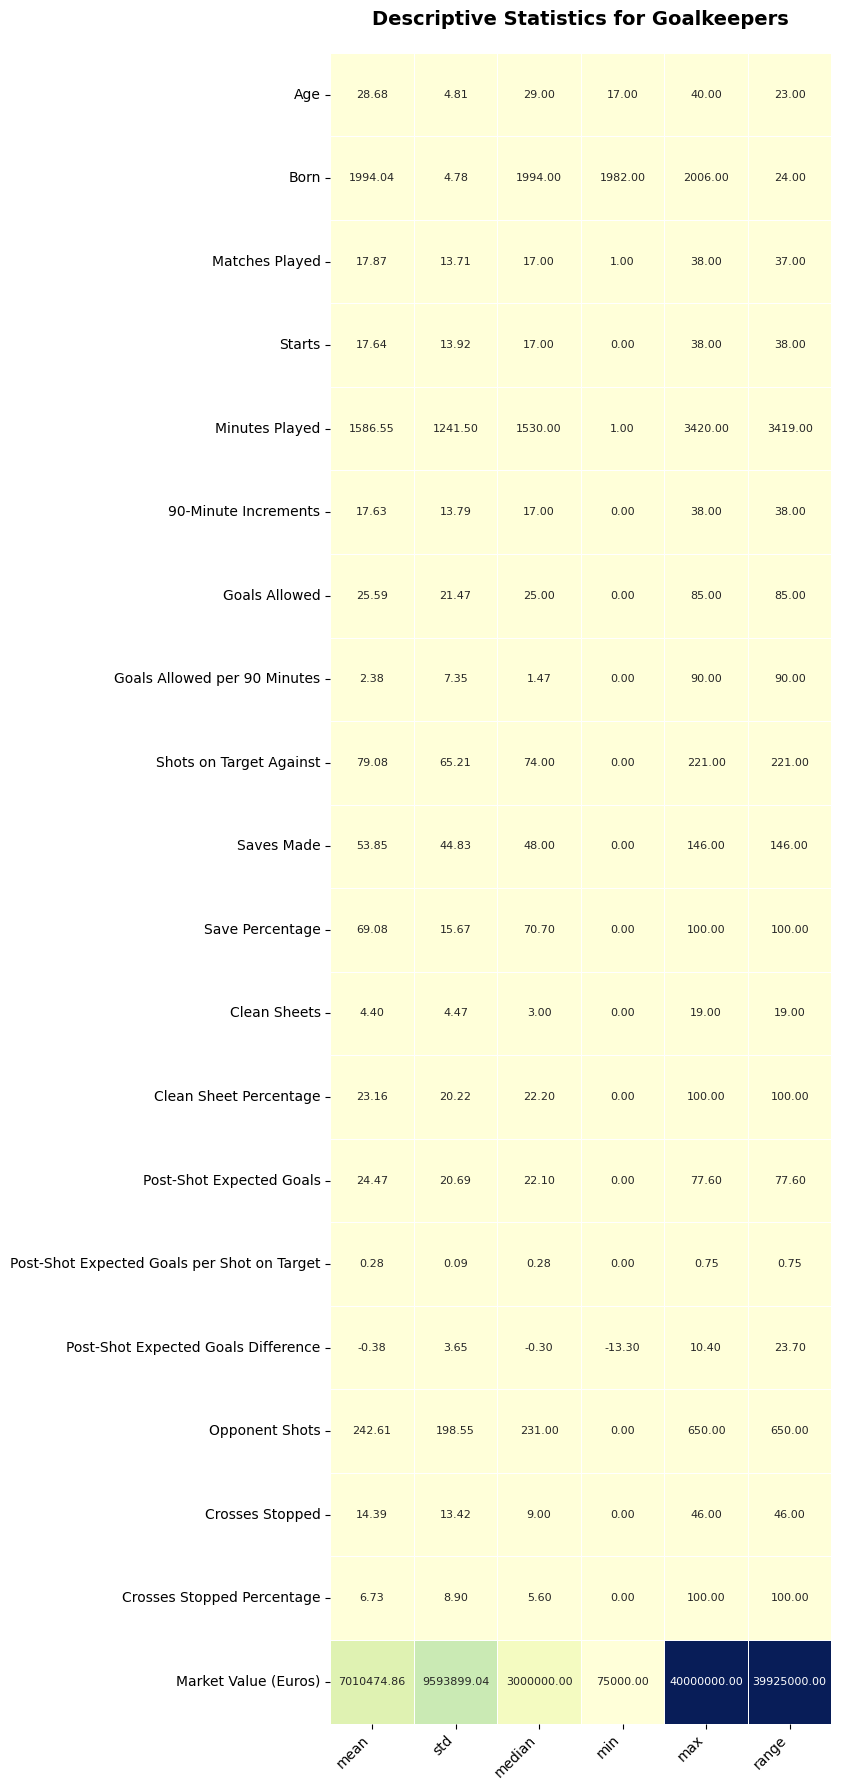

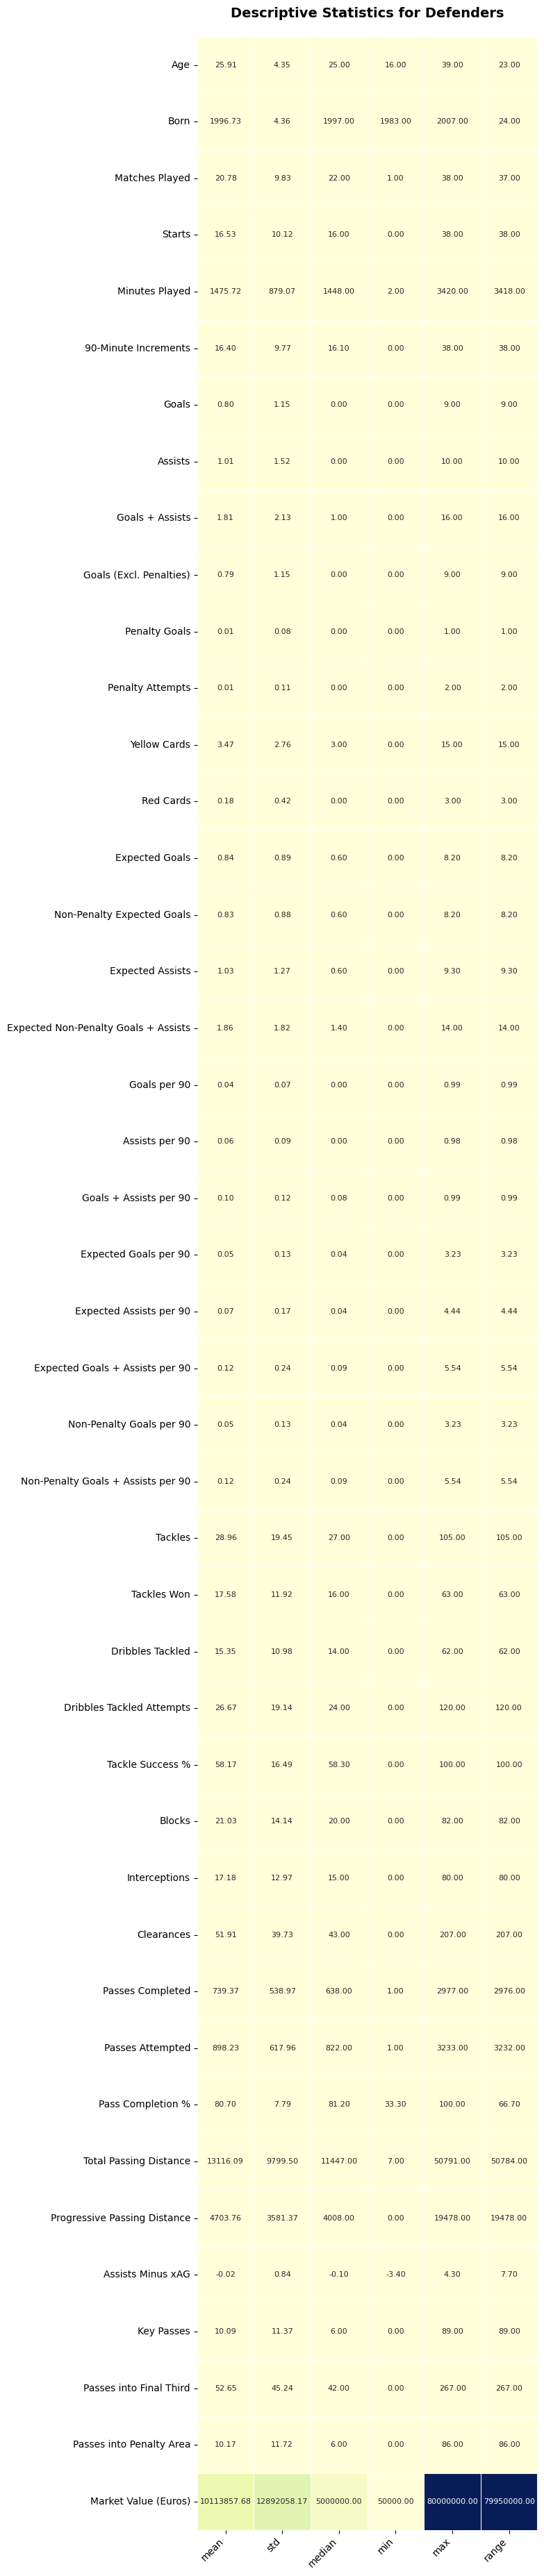

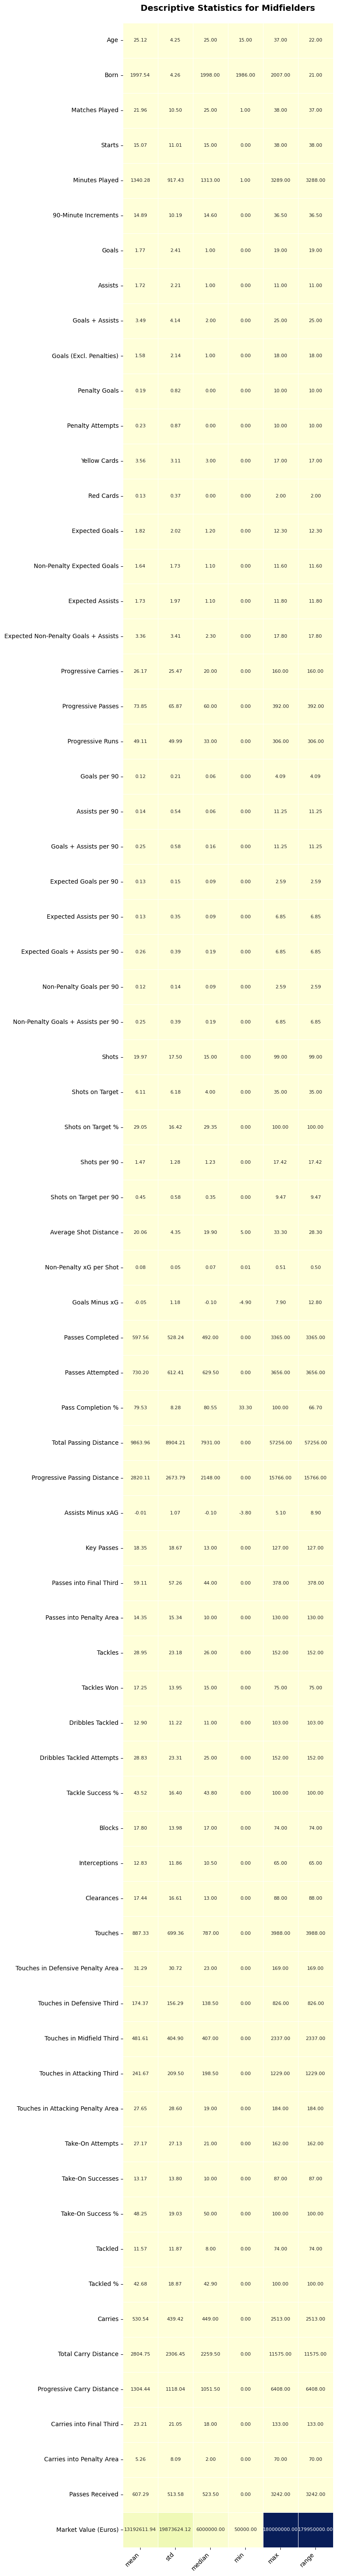

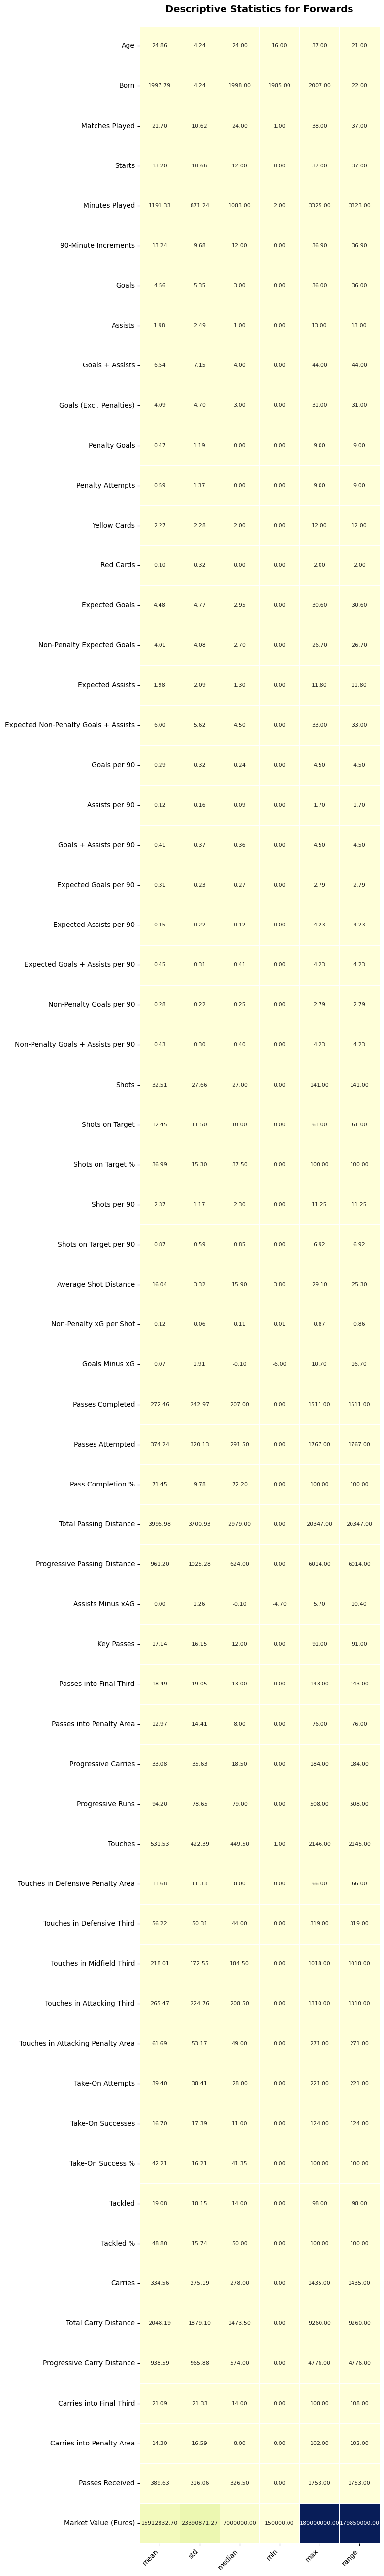

In [88]:
def display_heatmap(stats, title):
    fig, ax = plt.subplots(figsize=(12, len(stats) * 0.8 + 2))
    sns.heatmap(stats, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, 
                annot_kws={"size": 8}, ax=ax, square=True)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# generating and displaying heatmap tables for each position's statistics
for position, df in dataframes.items():
    stats = descriptive_stats(df)
    display_heatmap(stats, f"Descriptive Statistics for {position}")

The descriptive statistics for each of the positions highlight some of the key differences in their roles and performance metrics. One key difference is the number of performance metrics used in each of the positions, highlighting why it was important for us to split up the positions of the players in order to determine their market values. The goalkeepers have a large amount of defensive metrics like 'saves made' and 'clean sheet percentages' that other positions do not have. They also have the lowest maximum for market values out of the four players with the median 37 million euros lower than the maximum, suggesting that there is a low demand for goalkeepers, except for a couple of high-value players. For the defenders, there were important metrics like tackles and interceptions, which we would expect to be of value for defenders. The defenders have a maximum that is the 80 million euros and the median is  5 million euros which allows us to form a similar conclusion to that of goalkeepers. The midfielders have a wide variety of performance metrics, which we expected because the midfielder position has a lot of variation within it. It has a higher median value than the goalkeeper or defender position and a maximum value of 180 million which is significantly higher than the other two positions mentioned. The forwards have higher values in the offensive metrics like goals and assists, and have the highest median market value and a maximum market value of 180 million, suggesting that there is higher value in the forward position overall compared to the other positions. 

<a id="distribution-and-box-plot-visualization"></a>

## <div class='section'>Section 5: Distribution and Box Plot Visualization</div>

[Return to contents](#contents)

Here, we generate histograms and box plots for the key features across each player position show the distribution, and identify potential outliers. The key features were determined by analyzing the descriptive statistics in the previous section and highlighting the features that seemed the most relevant for each position. The histograms of the data provide insight into how data points are distributed while box plots reveal central tendencies and variability. 

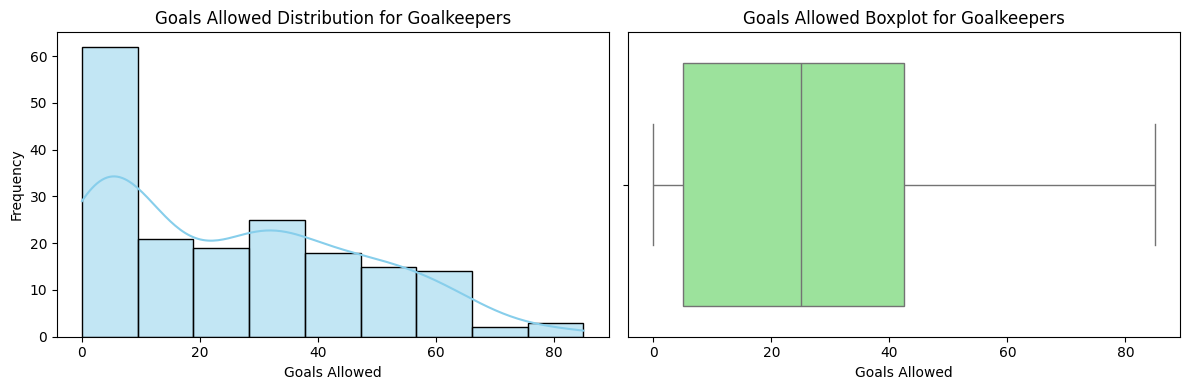

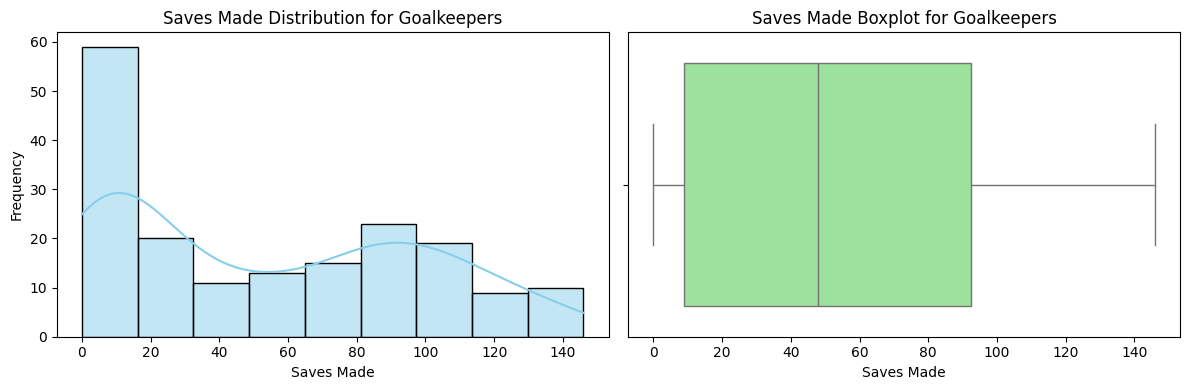

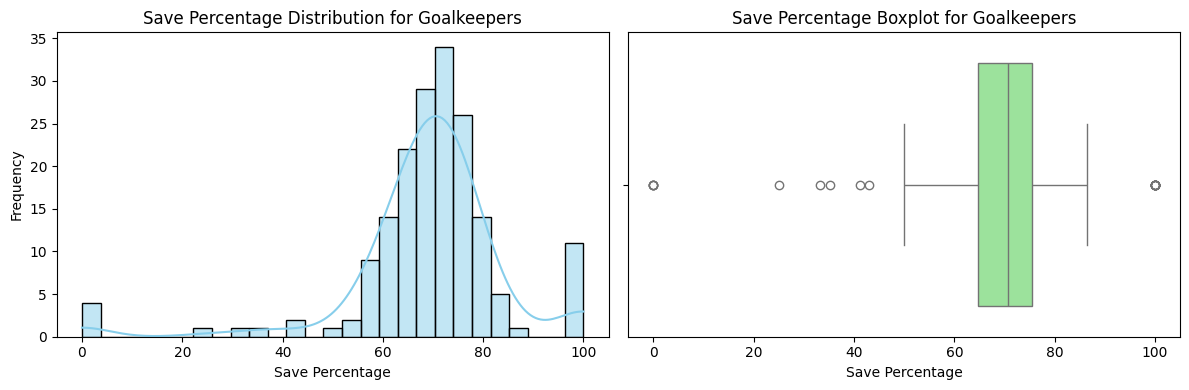

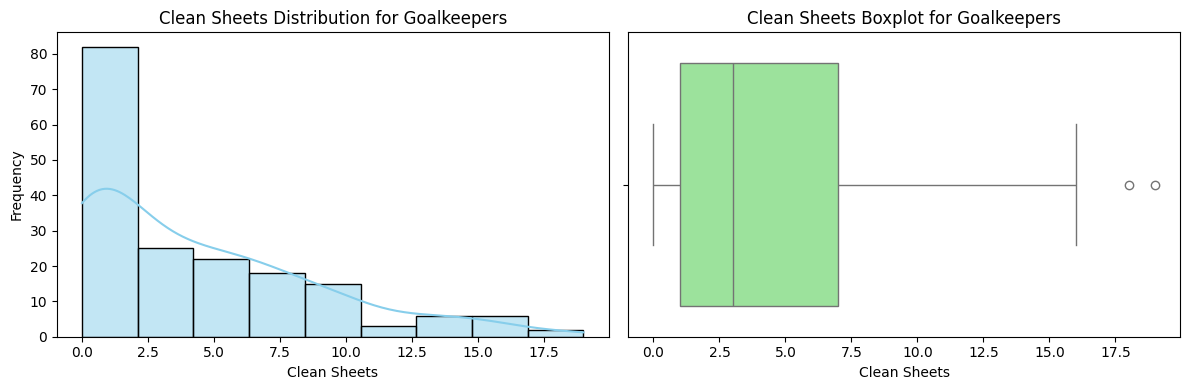

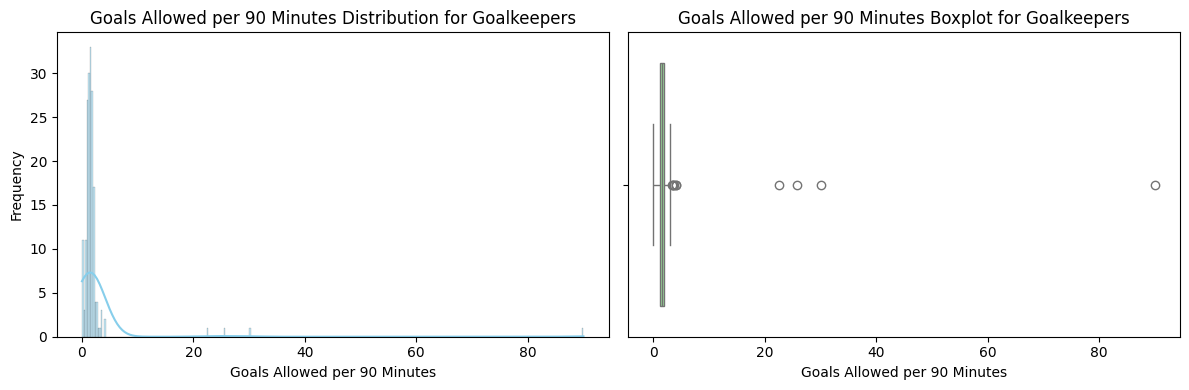

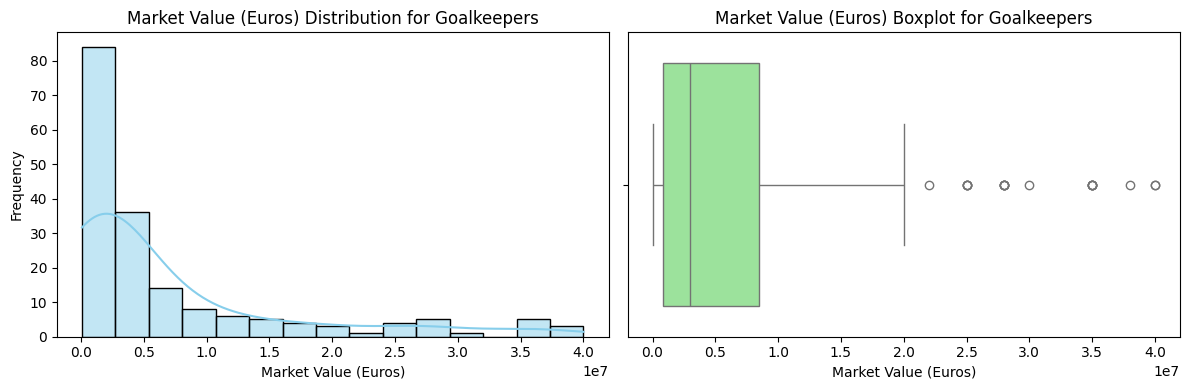

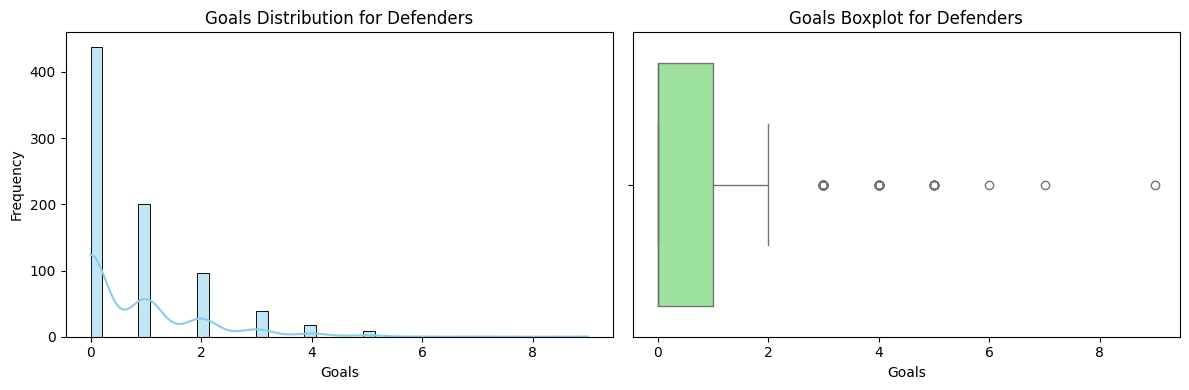

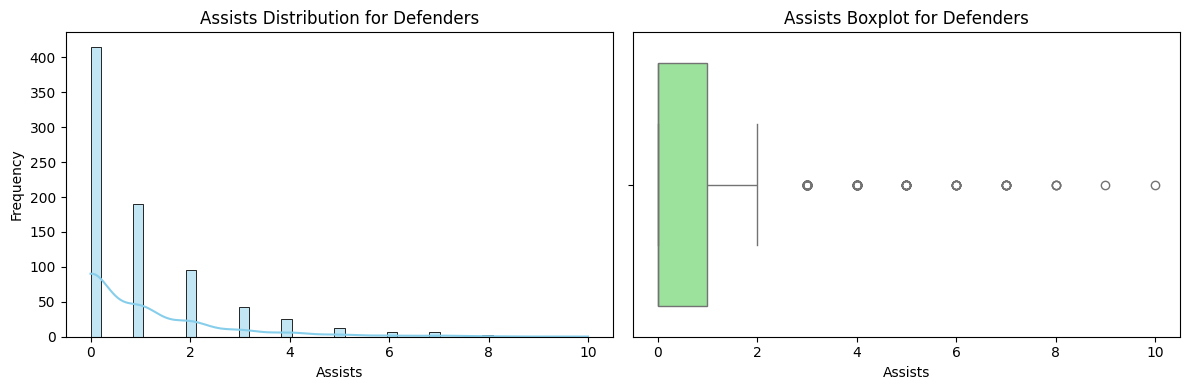

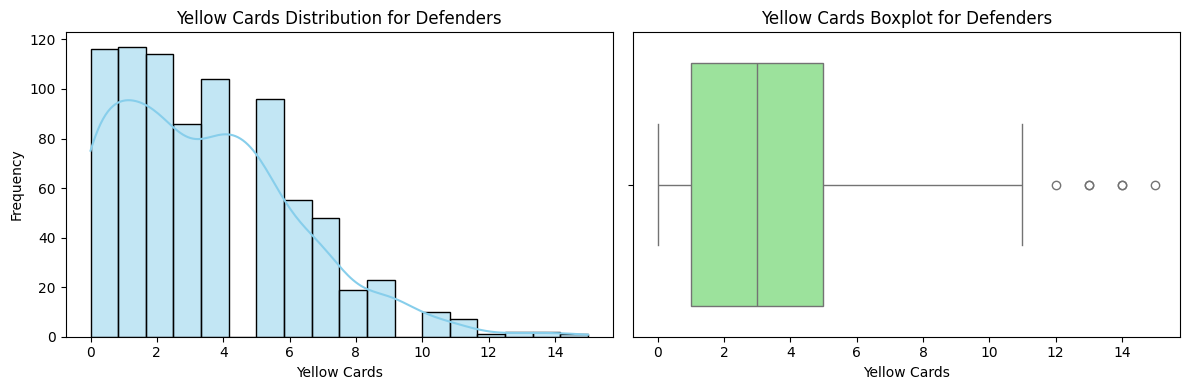

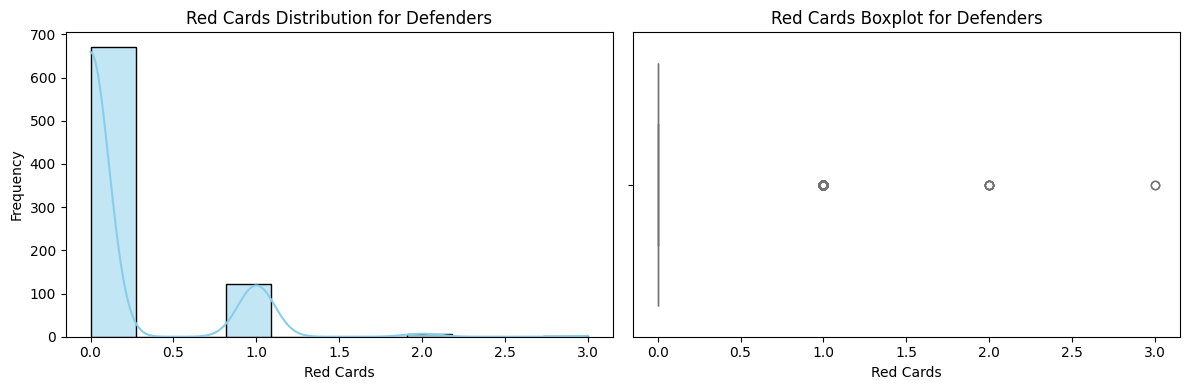

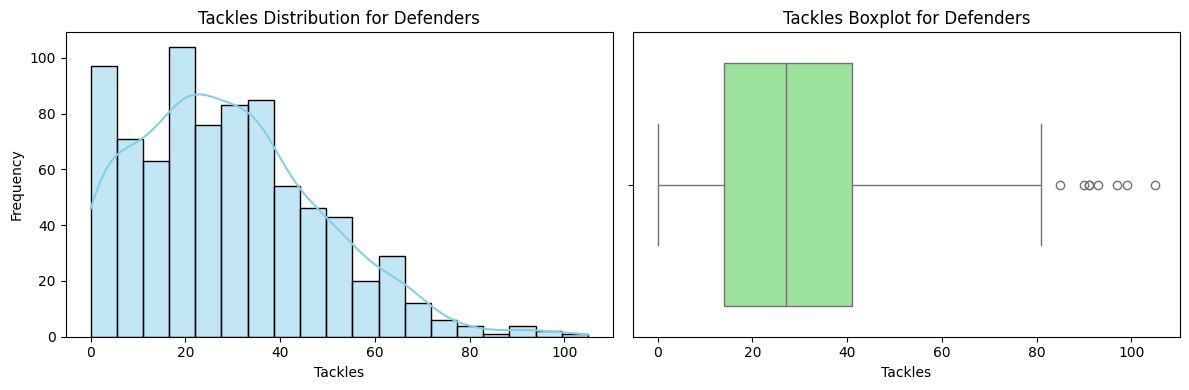

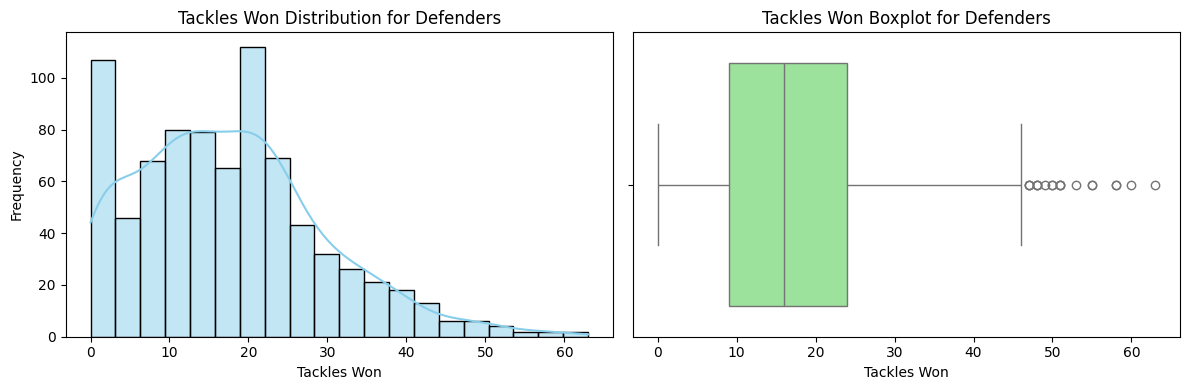

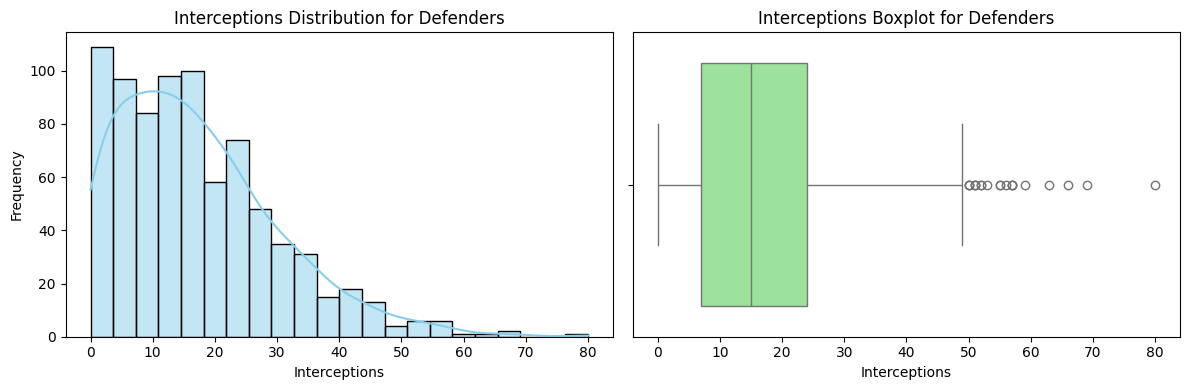

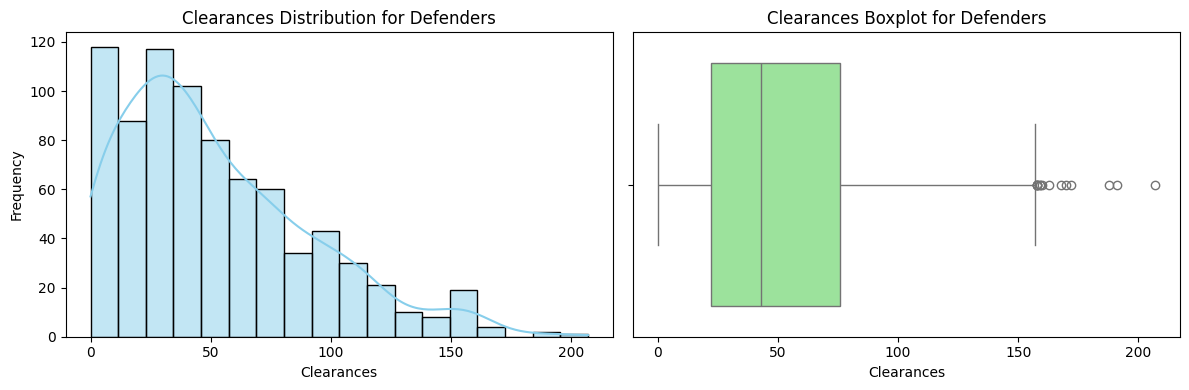

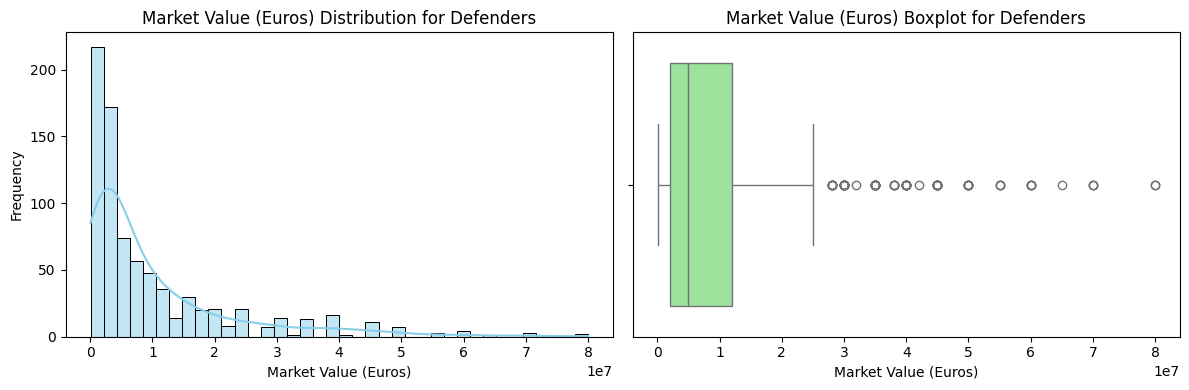

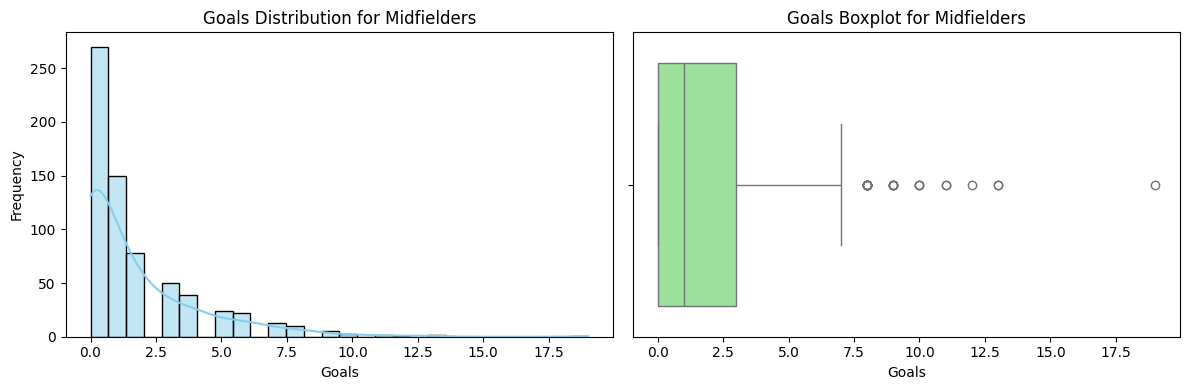

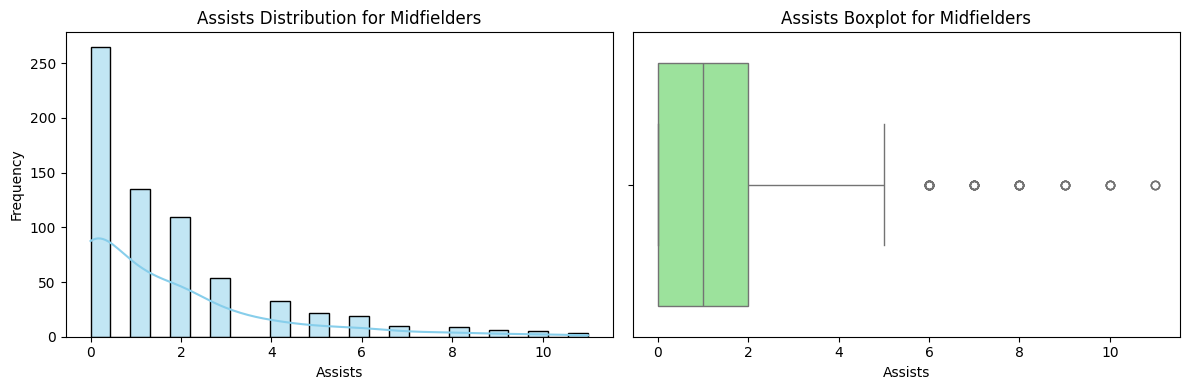

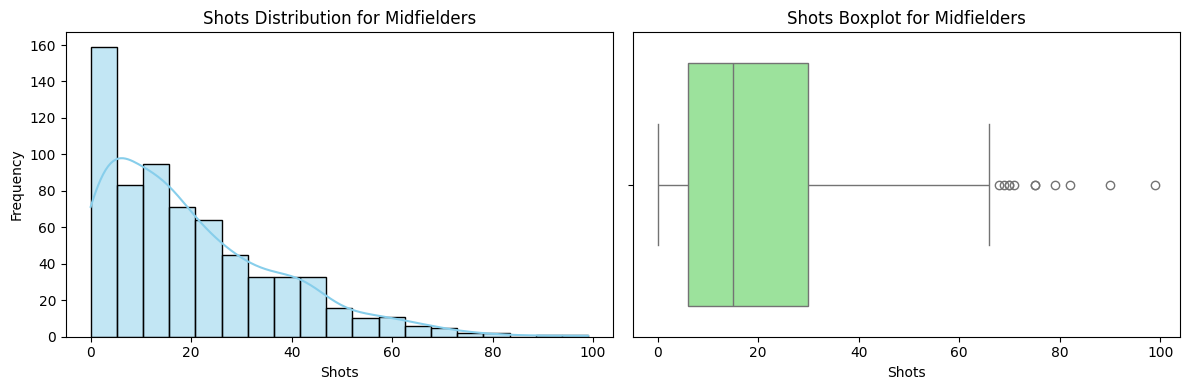

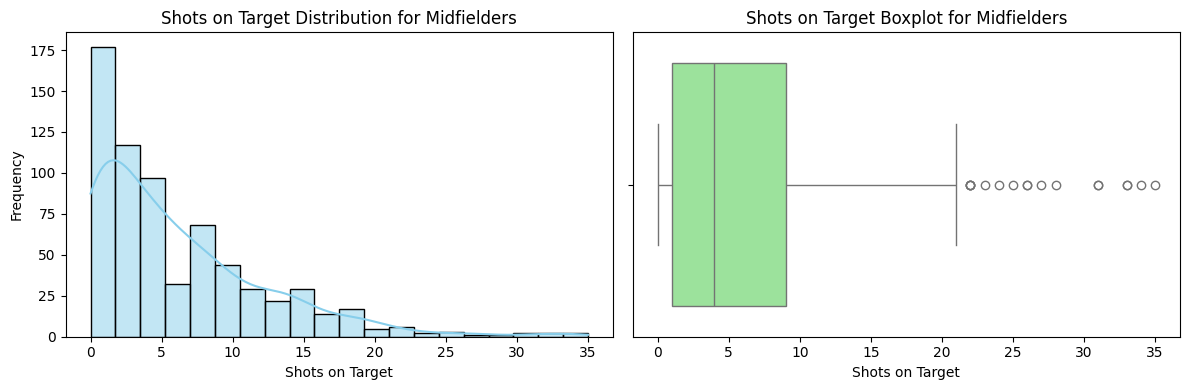

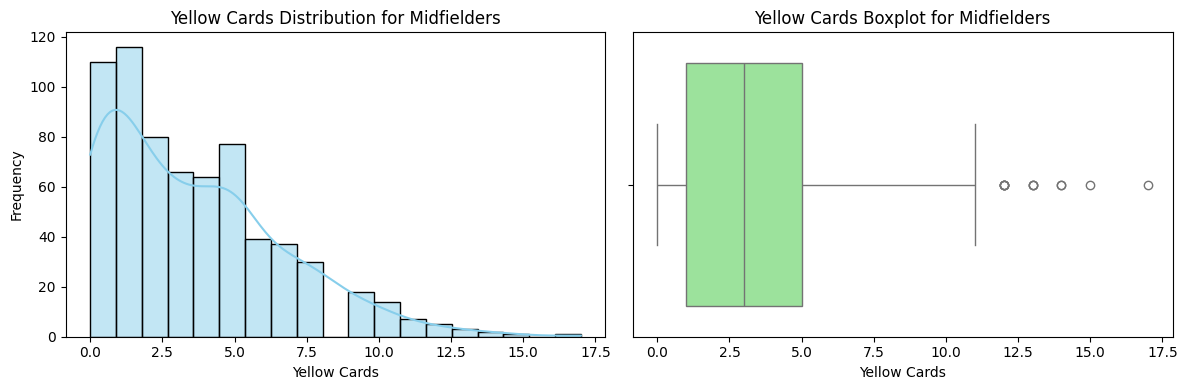

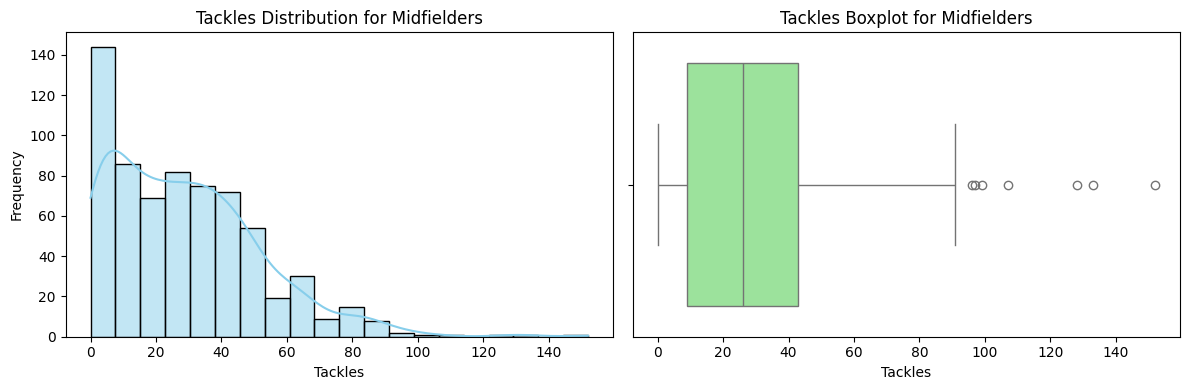

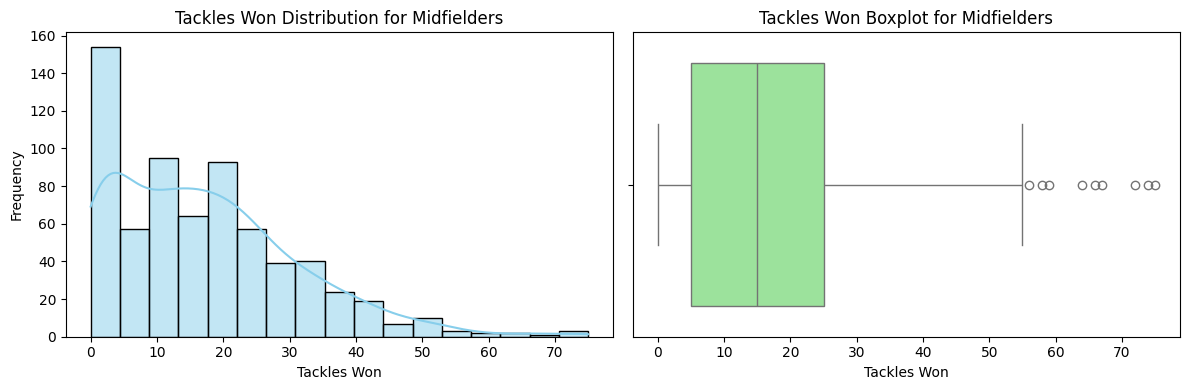

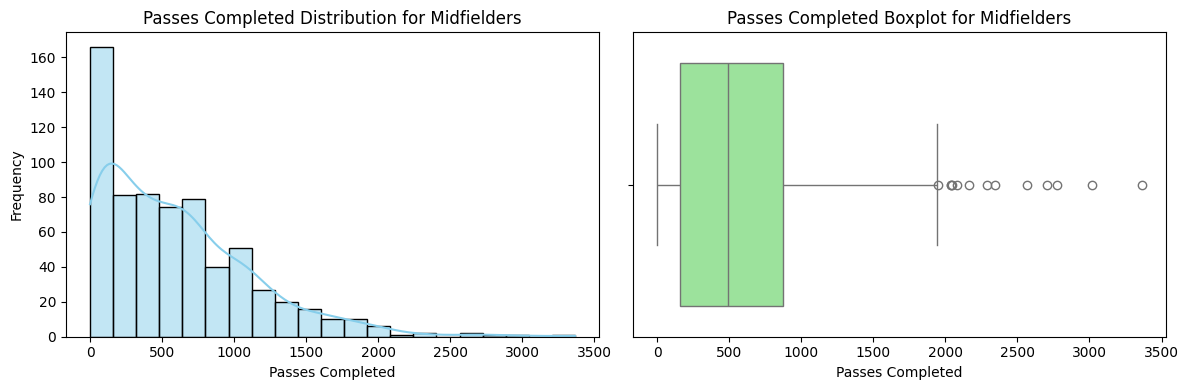

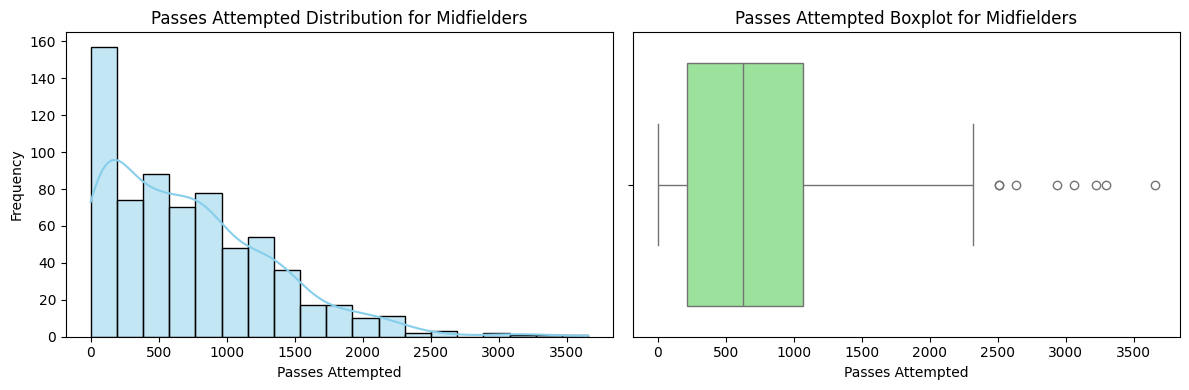

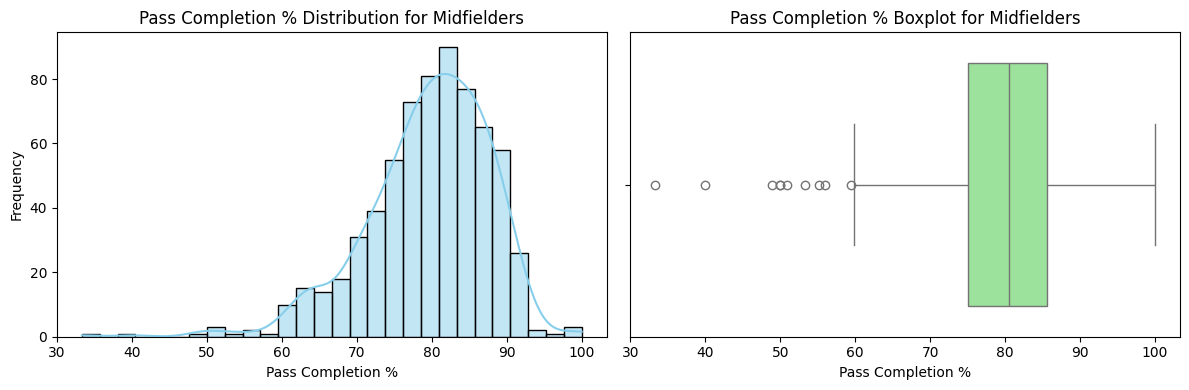

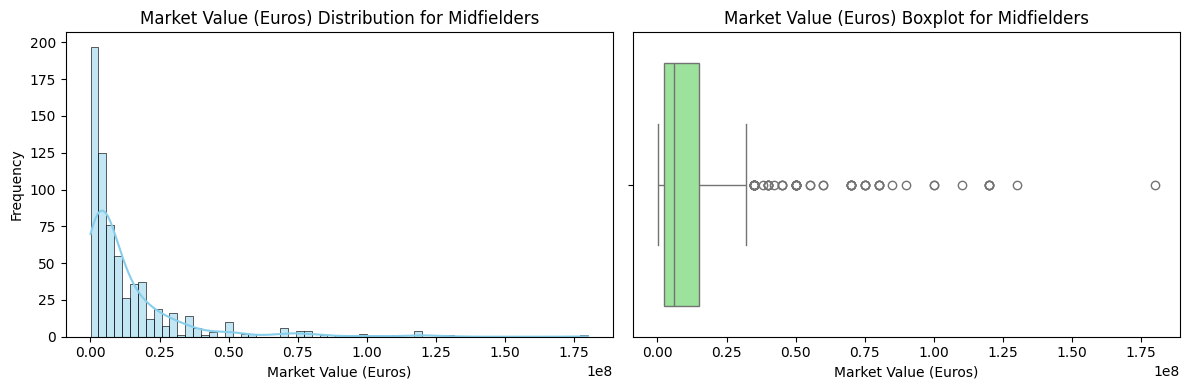

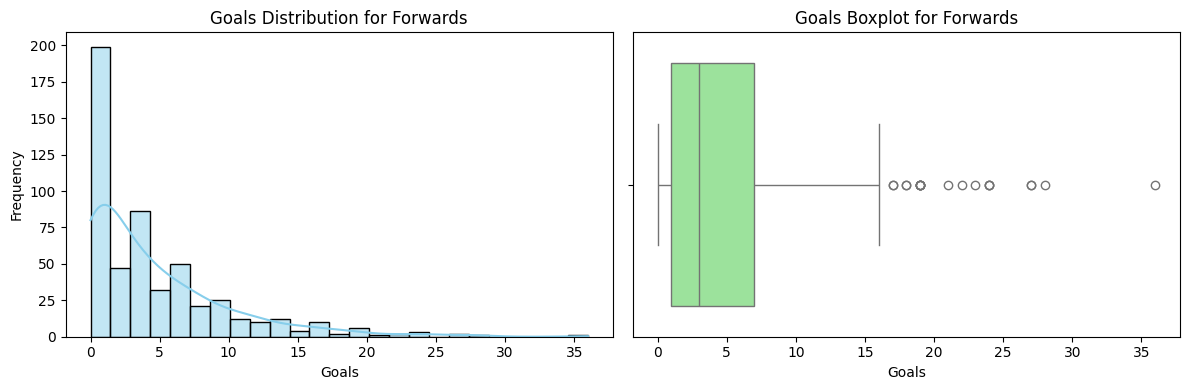

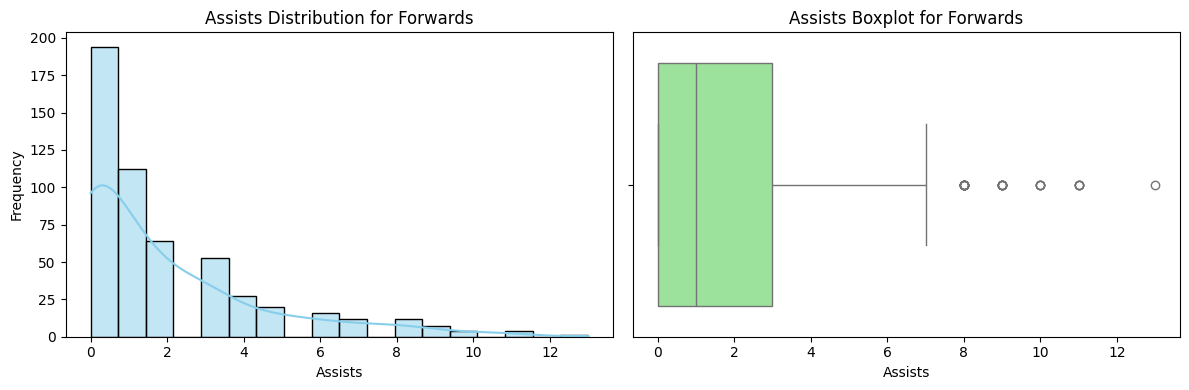

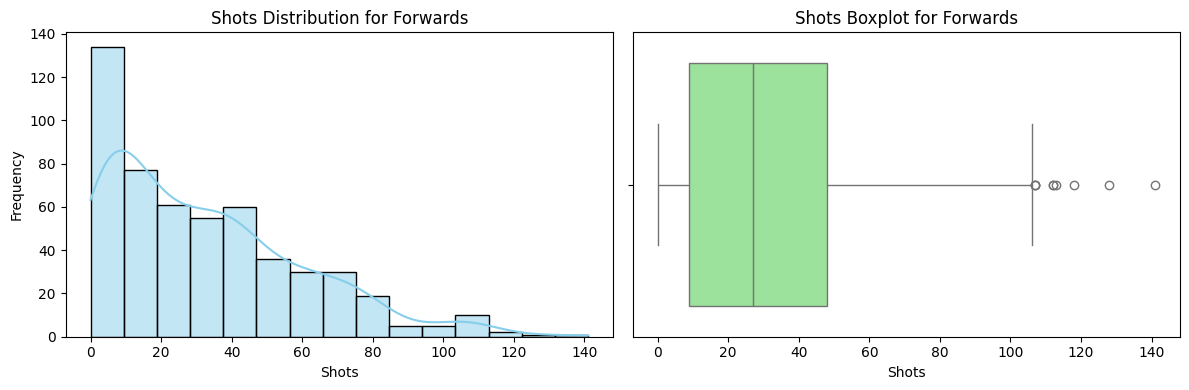

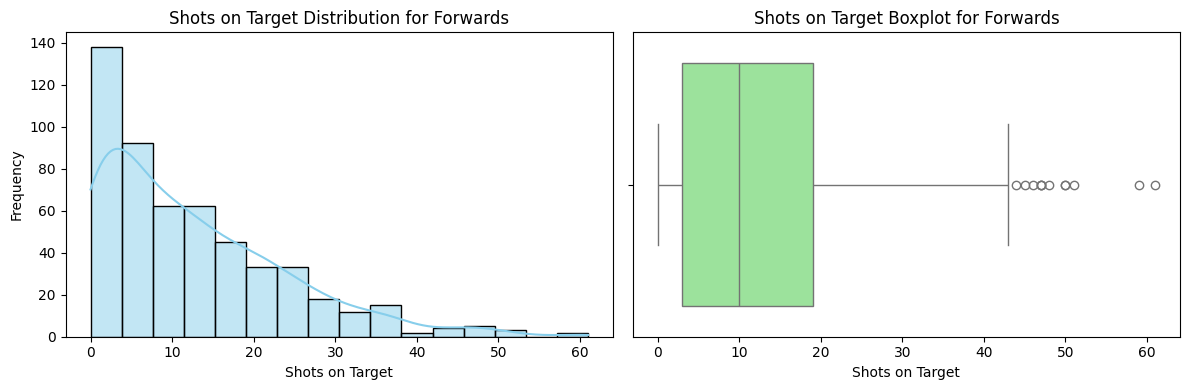

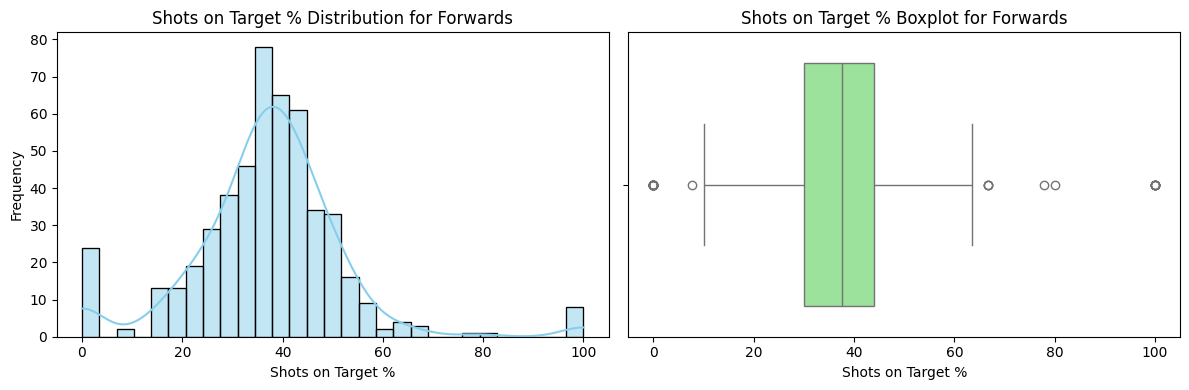

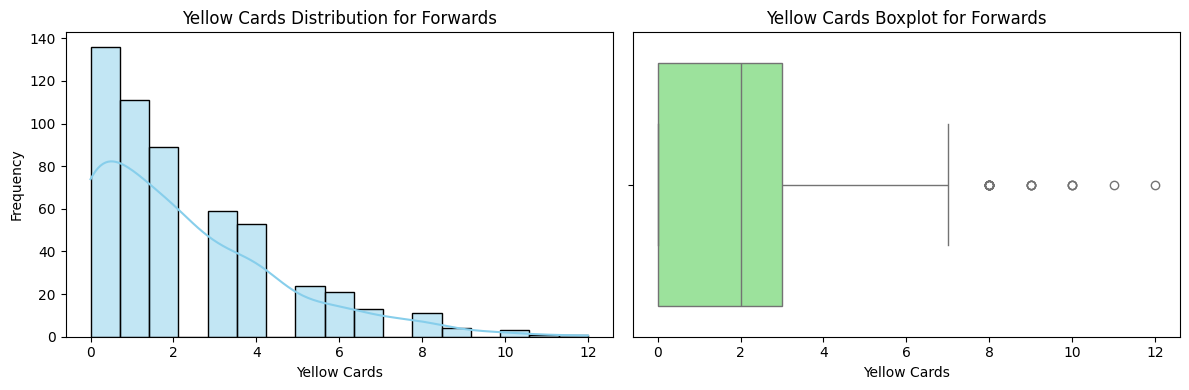

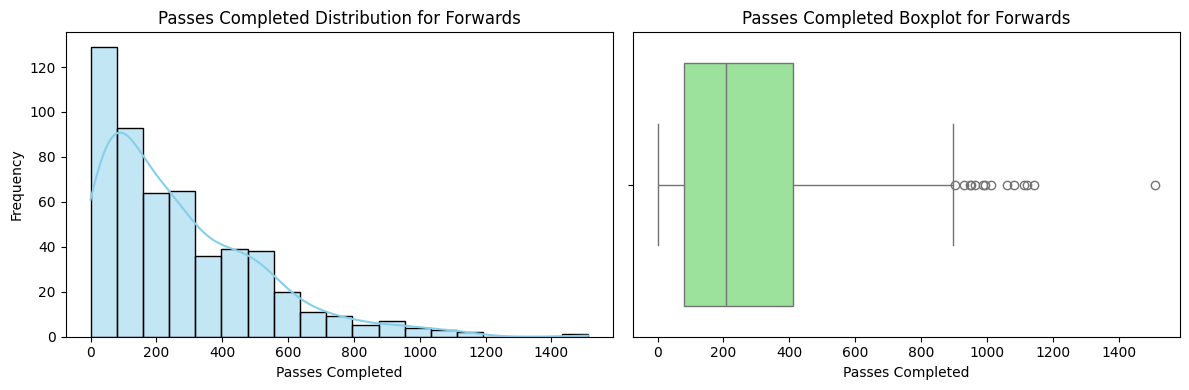

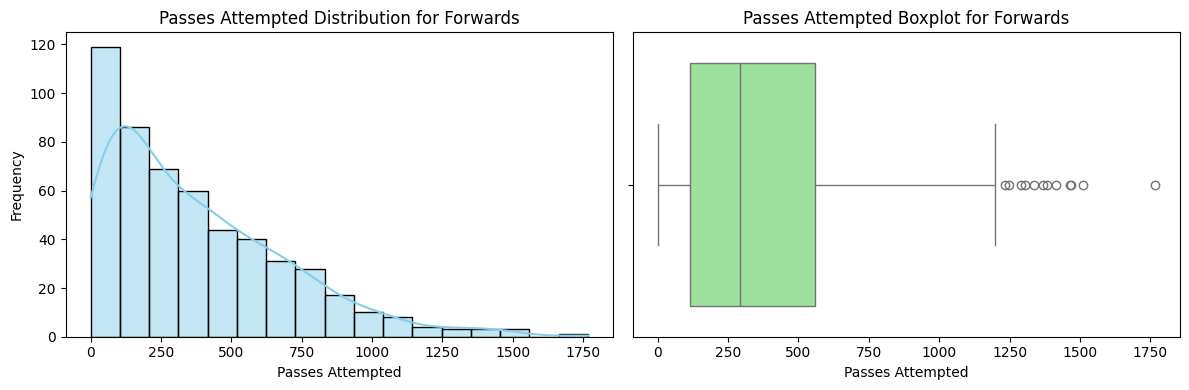

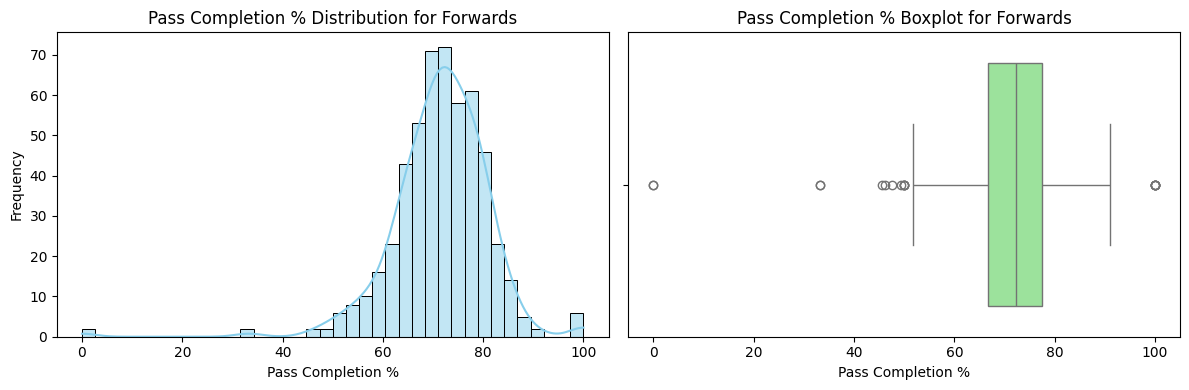

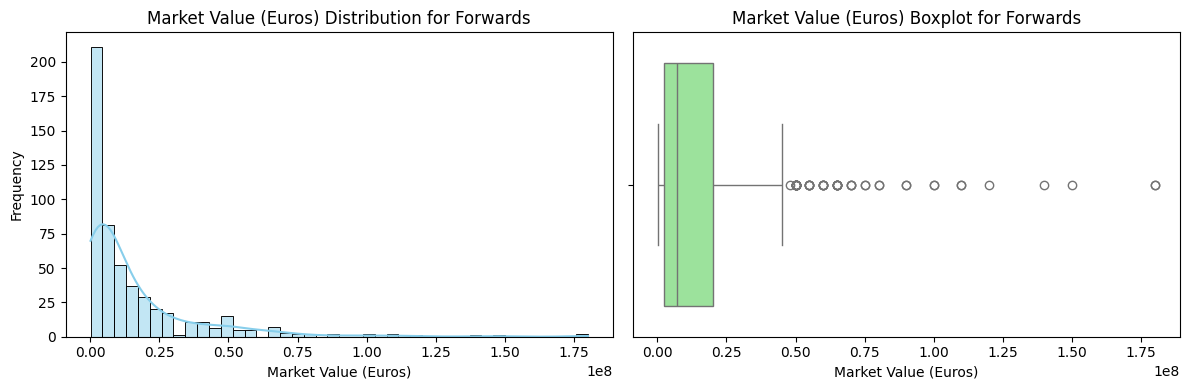

In [ ]:
#pertinent stats to each position
basic_stats = {
    'Goalkeepers': ['Goals Allowed', 'Saves Made', 'Save Percentage', 'Clean Sheets', 'Goals Allowed per 90 Minutes', 'Market Value (Euros)'],
    'Defenders': ['Goals', 'Assists', 'Yellow Cards', 'Red Cards', 'Tackles', 'Tackles Won', 'Interceptions', 'Clearances', 'Market Value (Euros)'],
    'Midfielders': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Yellow Cards', 'Tackles', 'Tackles Won', 'Passes Completed', 'Passes Attempted', 'Pass Completion %', 'Market Value (Euros)'],
    'Forwards': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Shots on Target %', 'Yellow Cards', 'Passes Completed', 'Passes Attempted', 'Pass Completion %', 'Market Value (Euros)']
}

def plot_and_save_plots(df, position, stats):
    for stat in stats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        label = column_mapping.get(stat, stat)

        # histogram
        sns.histplot(df[stat].dropna(), kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'{label} Distribution for {position}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Frequency')

        # boxplot
        sns.boxplot(x=df[stat].dropna(), ax=axes[1], color="lightgreen")
        axes[1].set_title(f'{label} Boxplot for {position}')
        axes[1].set_xlabel(label)

        plt.tight_layout()
        plt.show()


for position, df in dataframes.items():
    plot_and_save_plots(df, position, basic_stats[position])


The histograms show that the percentage-based data tends to be left-skewed, indicating that most players achieve relatively high percentages with very few underperformers. However, all of the other features were right-skewed, which suggests that a small group of super-star soccer players are the ones responsible for the higher values, which aligns with the conclusion we started to formulate after analyzing our descriptive statistics. This was the idea that there are that the few elite players have drastically higher market values than the general pool of players in the same positions.  

<a id="correlation-heatmaps"></a>

## <div class='section'>Section 6: Correlation Heatmaps</div>

[Return to contents](#contents)

Finally, we create correlation heatmaps to explore any positive or negative relationships between features for each player position. This step is helpful for further analysis or model building. Again we used the key features that were determined by analyzing the descriptive statistics and highlighting the features that seemed the most relevant for each position.


Generating correlation heatmap for Goalkeepers...


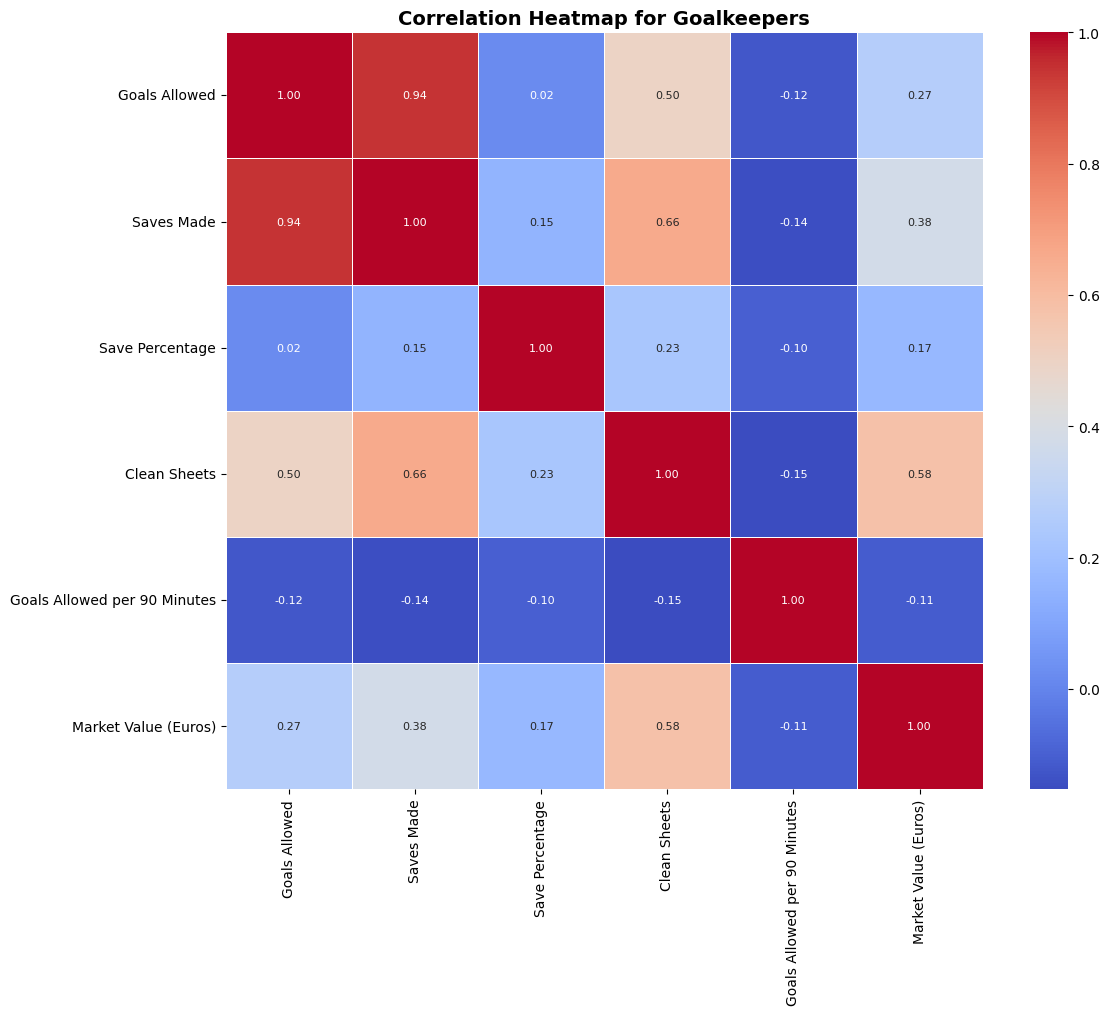

Generating correlation heatmap for Defenders...


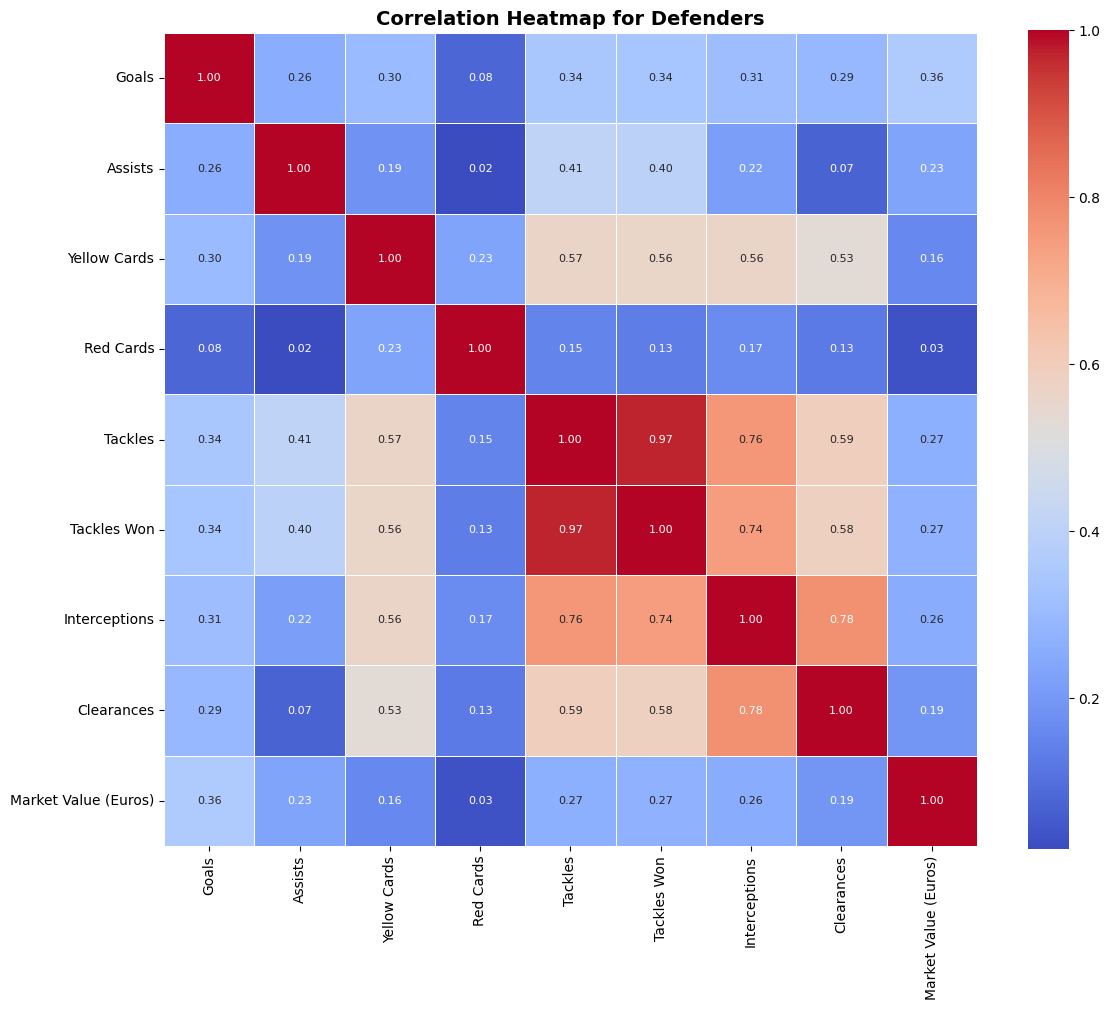

Generating correlation heatmap for Midfielders...


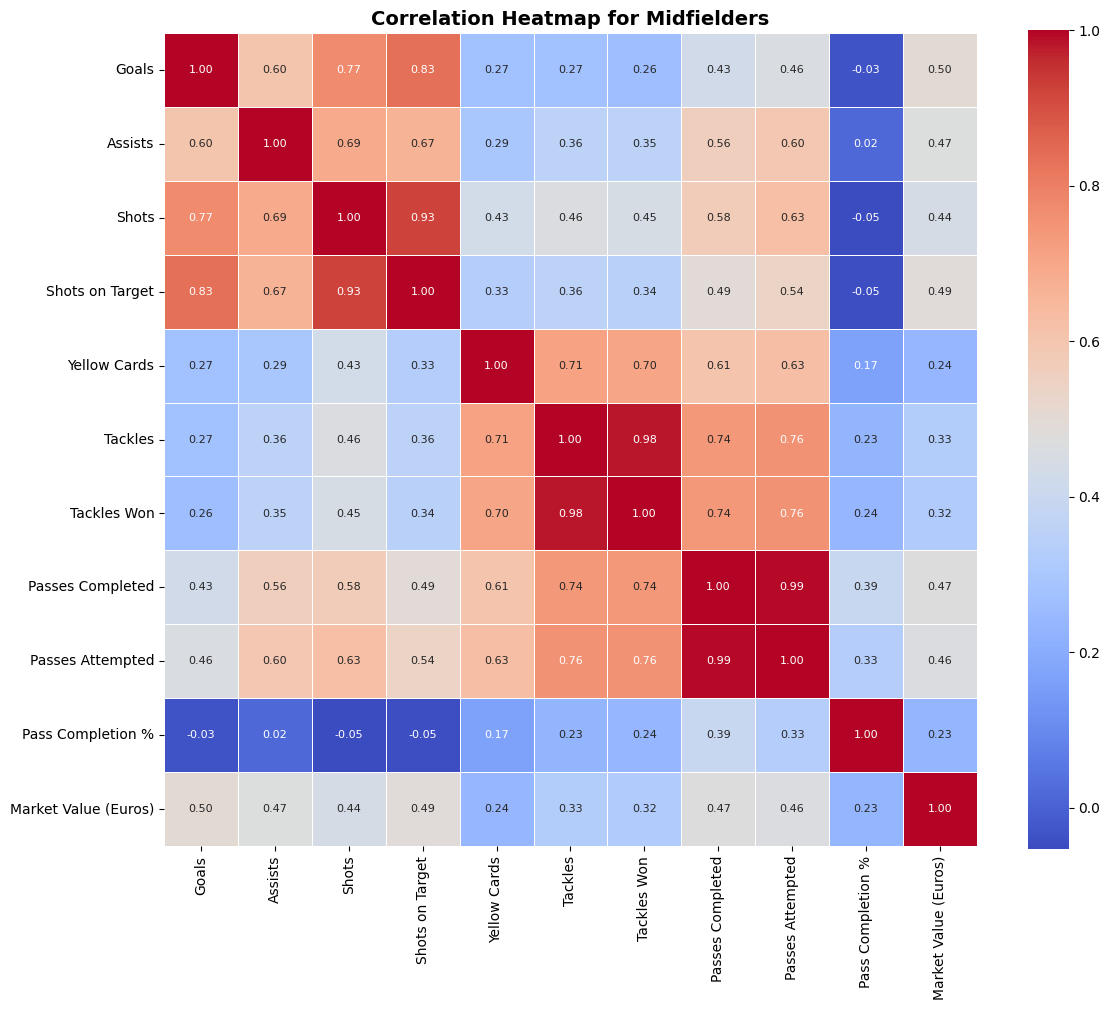

Generating correlation heatmap for Forwards...


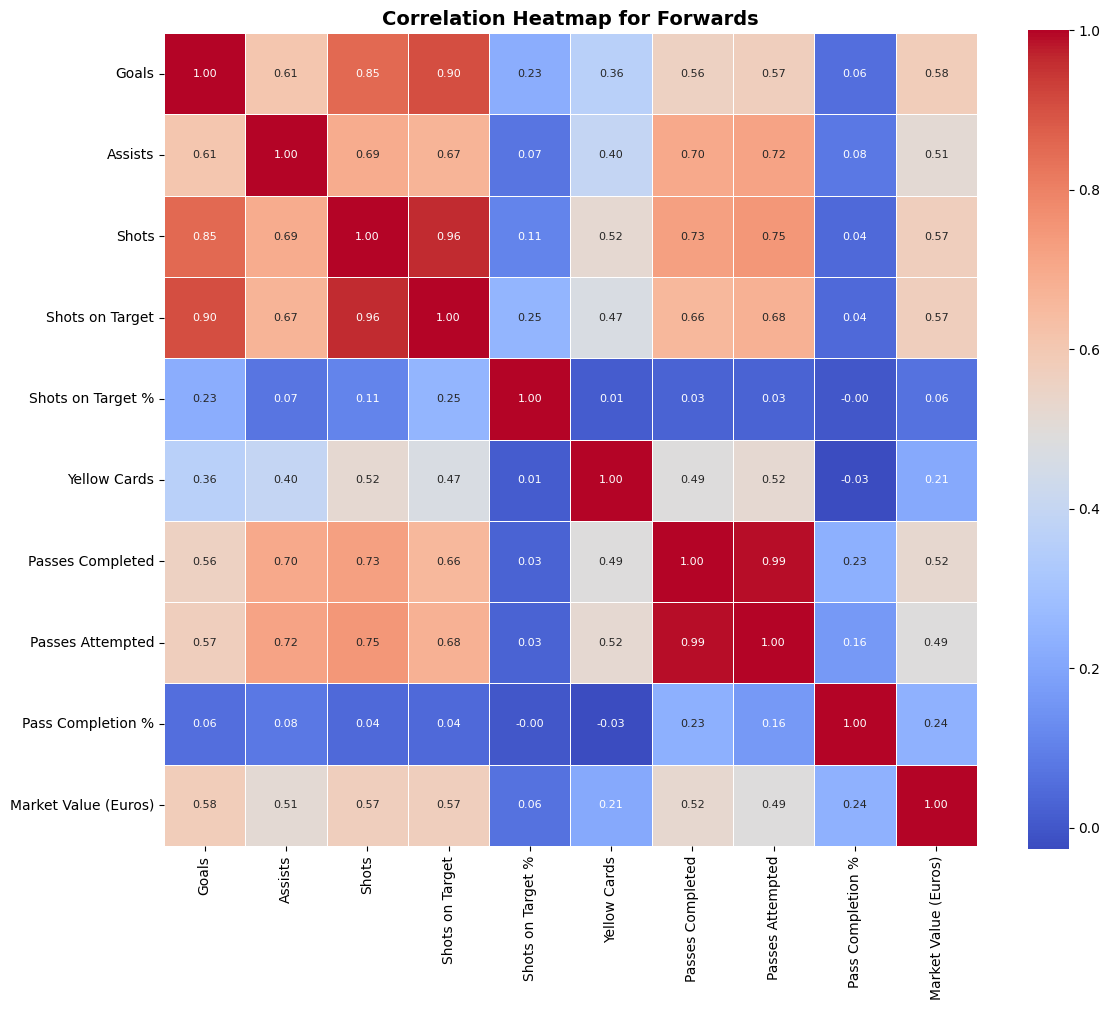

In [145]:
def save_correlation_heatmap(df, position, stats):
    #filter the dataframe to include only relevant stats
    df_filtered = df[stats]
    
    #compute correlation matrix
    corr = df_filtered.corr()
    
    #create heatmap with annotations
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
                linewidths=0.5, annot_kws={"size": 8})
    
    #add title and format layout
    plt.title(f'Correlation Heatmap for {position}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    
    #display the heatmap
    plt.show()


# generating and saving correlation heatmaps for each position
for position, df in dataframes.items():
    print(f"Generating correlation heatmap for {position}...")
    save_correlation_heatmap(df, position, basic_stats[position])


The heatmaps reveals many important relationships between the features for each position. For the goalkeeper position, the 'Goals Allowed' was strongly correlated with 'Saves made'. 'Clean Sheets' had a slight positive correlation with market value, which we thought was interesting because it was the strongest correlated feature to market value for the goalkeeper position. For defenders, 'Tackles' and 'Interceptions" are highly correlated, but the market value had a weak correlation to all of the features, which suggests that there may be other features are more impactful for market value for degenders. For midfielders, there were strong correlations between 'Goals' and 'Shots', and the market value correlates the strongest with 'Goals'. For the forward position, 'Shots', 'Shots on Target' and 'Goals' hav every strong correlations, and all three have the strongest correlation with market value. Compared to the other positions, the forward position, with the midfielder position in second place, has the most skill based features with stronger correlations to market value. 

<a id="PCA"></a>

## <div class='section'>Section 7: Principal Component Analysis</div>

Here, we utilize Principal Component Analysis to reduce the dimensionality of our dataset while maximizing the variance. It is also helpful for determining which features contribute the most to the variance and also contribute the most to the principal components. 

[Return to contents](#contents)

<a id="defense-pca"></a>

### <div class='subsection'>7.1 Defense Position PCA</div>

In this section, we split the defender data into training and testing data. Then we determine the number of principal components required to explain 95% of the variance. These principal components are what we will use in our base models. Then we project the data onto those principal components. We look at the top 10 defenders based on the first principal component to check with online data and see how the top 10 players we see compared to the data online. Then we visualize the 2D PCA projection of all defenders while highlighting the top 10 players. Then we analyze the top 40 predictor contributions to the first principal component to understand which features are determining the data we see. 


The total number of components is: 43.
The number of components required to explain 95% of the variance is: 15.


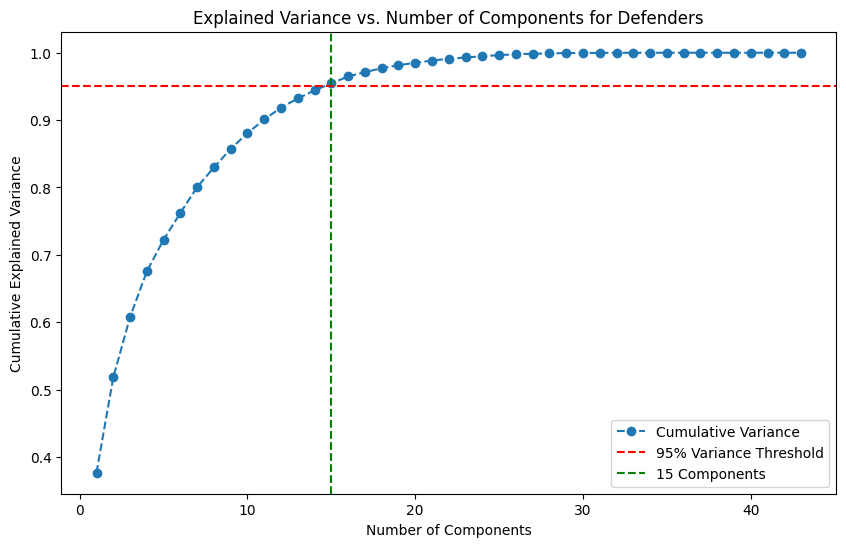

In [143]:
x_defender_train, x_defender_test, y_defender_train, y_defender_test = train_test_split(
    x_defenders, y_defenders, test_size=0.2, random_state=109
)

#apply pca to defender training and test data
pca = PCA()
defender_train_pca = pca.fit_transform(x_defender_train)
defender_test_pca = pca.transform(x_defender_test)

#calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

#find the number of components explaining 95% of variance
defender_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {defender_valid_components}.")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=defender_valid_components, color='g', linestyle='--', label=f'{defender_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Defenders')
plt.legend(loc='best')
plt.show()


In [144]:
pca_95 = PCA(n_components=defender_valid_components)

#apply pca with valid components to training and test data
defender_train_pca_95 = pca_95.fit_transform(x_defender_train)
defender_test_pca_95 = pca_95.transform(x_defender_test)

#calculate explained variance for selected components
explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_95 = np.cumsum(explained_variance_ratio_95)

#split indices for linking players with pca results
x_defender_train_indices, x_defender_test_indices, y_defender_train, y_defender_test = train_test_split(
    defenders.index, y_defenders, test_size=0.2, random_state=109
)

#prepare training dataframe with pca components and player info
x_defender_train_df = pd.DataFrame(defender_train_pca_95, columns=[f"PC{i+1}" for i in range(defender_train_pca_95.shape[1])])
x_defender_train_df['Player'] = defenders.iloc[x_defender_train_indices]['Player'].values

#prepare test dataframe with pca components and player info
x_defender_test_df = pd.DataFrame(defender_test_pca_95, columns=[f"PC{i+1}" for i in range(defender_test_pca_95.shape[1])])
x_defender_test_df['Player'] = defenders.iloc[x_defender_test_indices]['Player'].values

#select the top 10 defenders based on PC1
top_defenders = x_defender_train_df.nlargest(10, 'PC1')
print("Top 10 defenders based on PC1:")
print(top_defenders[['Player', 'PC1']])


Top 10 defenders based on PC1:
                  Player     PC1
434          Pedro Porro  13.131
387  Giovanni Di Lorenzo  11.190
306     Antonee Robinson  10.190
296     Jeremie Frimpong   9.911
602      Cristian Romero   9.469
86    Nico Schlotterbeck   9.426
253        Sergi Cardona   9.339
581        Alfie Doughty   9.161
491      Kieran Trippier   9.077
347       Theo Hernández   9.045


We thought that this this information would be interesting to note so that when we did our later comparisons we could have another metric to use to compare models with each other. We also wanted to compare these results to our general knowledge of who we know some of the top defenders in these to be.

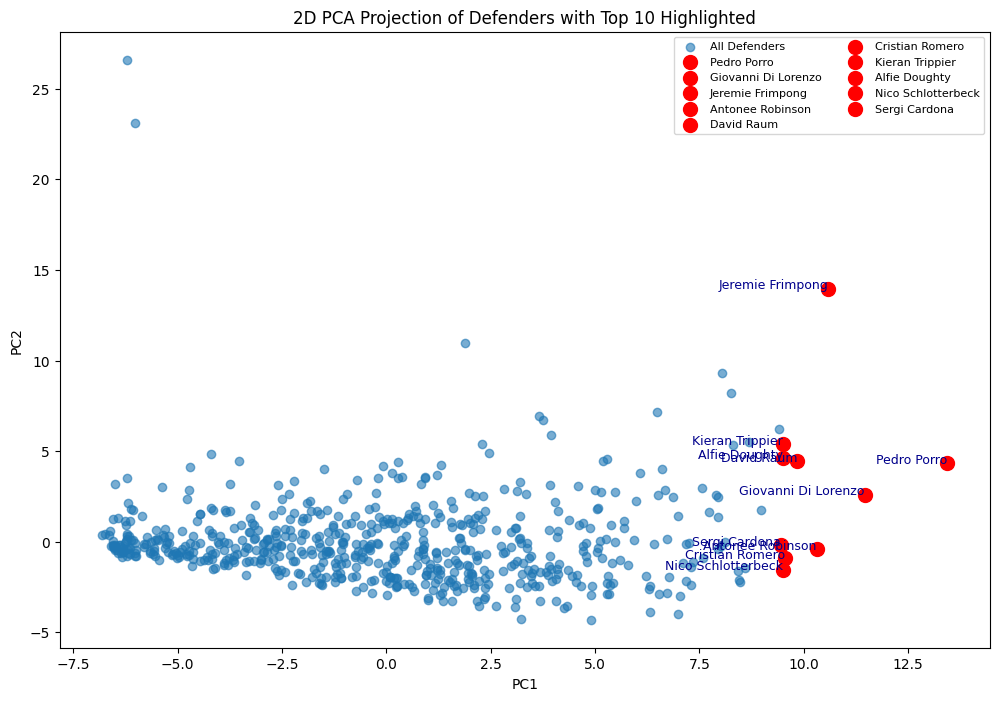

In [93]:
plt.figure(figsize=(12, 8))
plt.scatter(defender_train_pca[:, 0], defender_train_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_defenders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defenders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

This plot demonstrates that most of the defenders are clustered in the lower PC2 and are spread across the PC1 region, indicating a stronger correation with PC1 than PC2. We can see this reflected in the steepness of the explained variance vs. number of components graph above. The top 10 defenders are along the positive PC1 axis, which suggests that their metrics contribute significantly to PC1. 

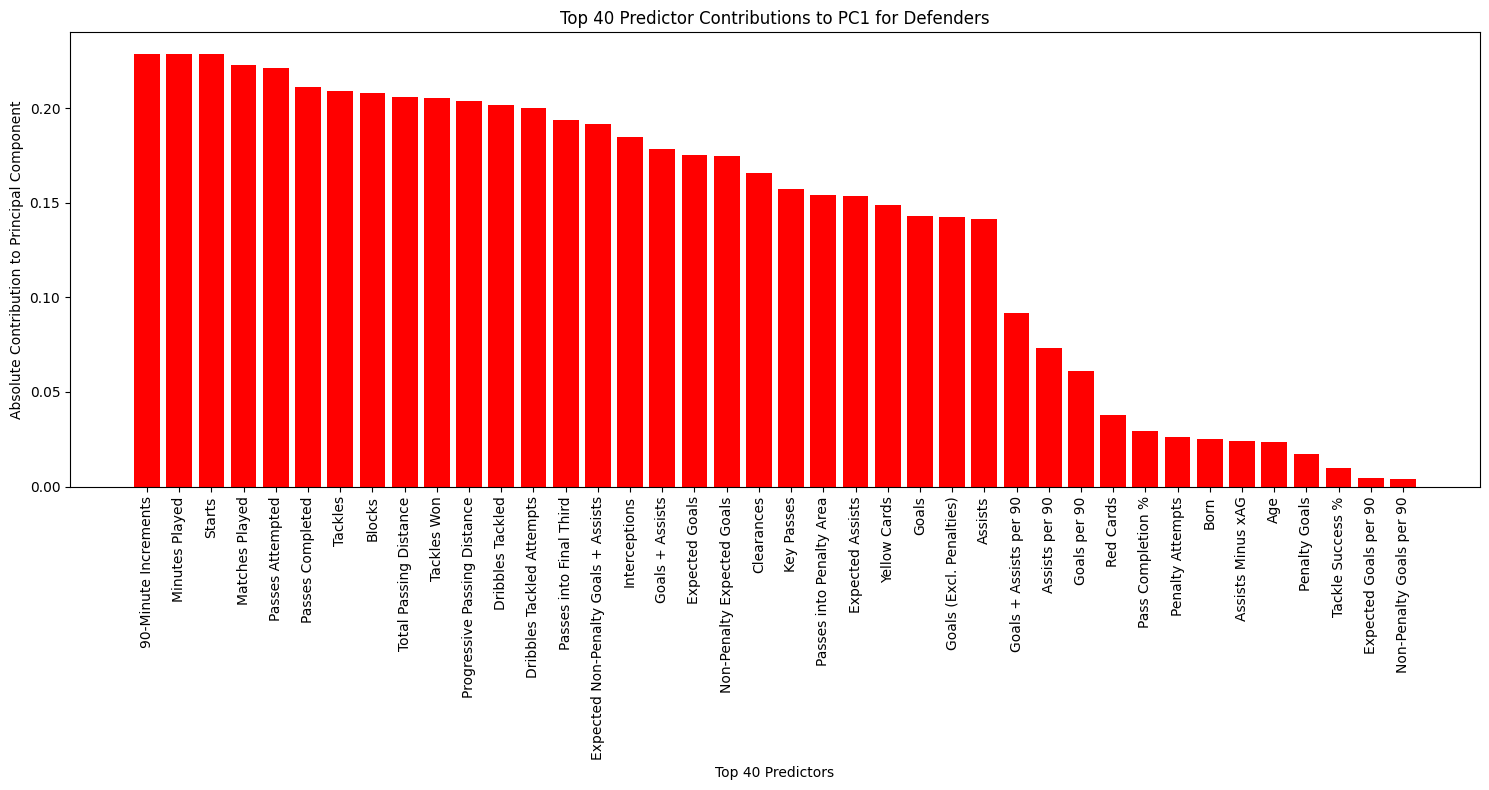

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
feature_names = defenders.select_dtypes(include=[np.number]).columns
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = feature_names[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1 for Defenders')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

Here, we can see the most important features of our first principal components. The most important ones for defenders are the '90 Minute Increments', 'Minutes Played', 'Starts', 'Matches Played', 'Passes Attempted', 'Passes Completed', 'Tackles', and 'Blocks'. We expected tackles and blocks to be important contributors to the principal components for defenders because those skills are defensive techniques. Additionally, the strong correlation between the number of minutes/matches played and how long the players play was important to note because it indicates that players with more skill have more playing time, and are also likely to have a higher market value. 

<a id="midfielder-pca"></a>

### <div class='subsection'>7.2 Midfielder Position PCA</div>

In this section, we split the midfielder data into training and testing data. Then we determine the number of principal components required to explain 95% of the variance. These principal components are what we will use in our base models. Then we project the data onto those principal components. We look at the top 10 midfielders based on the first principal component to check with online data and see how the top 10 players we see compared to the data online. Then we visualize the 2D PCA projection of all midfielders while highlighting the top 10 players. Then we analyze the top 40 predictor contributions to the first principal component to understand which features are determining the data we see. 

[Return to Section 8](#PCA)

The total number of components is: 71.
The number of components required to explain 95% of the variance is: 20.


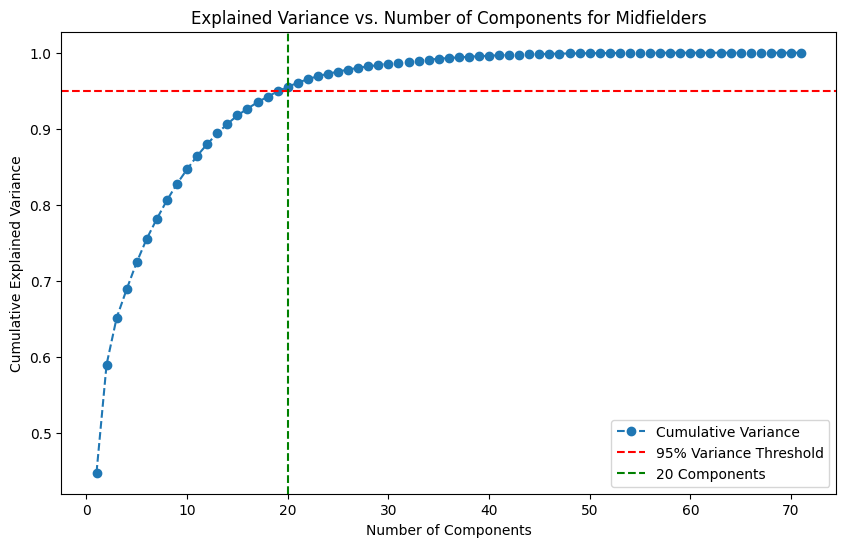

In [141]:
x_midfielder_train, x_midfielder_test, y_midfielder_train, y_midfielder_test = train_test_split(
    x_midfielders, y_midfielders, test_size=0.2, random_state=109
)

#apply pca to midfielder training and test data
pca = PCA()
midfielder_train_pca = pca.fit_transform(x_midfielder_train)
midfielder_test_pca = pca.transform(x_midfielder_test)

#calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

#find the number of components explaining 95% of variance
midfielder_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {midfielder_valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=midfielder_valid_components, color='g', linestyle='--', label=f'{midfielder_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Midfielders')
plt.legend(loc='best') 
plt.show()

In [142]:
pca_95 = PCA(n_components=midfielder_valid_components)

#apply pca with valid components to training and test data
midfielder_train_pca_95 = pca_95.fit_transform(x_midfielder_train)
midfielder_test_pca_95 = pca_95.transform(x_midfielder_test)

#calculate explained variance for selected components
explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_95 = np.cumsum(explained_variance_ratio_95)

#split indices for linking players with pca results
x_midfielder_train_indices, x_midfielder_test_indices, y_midfielder_train, y_midfielder_test = train_test_split(
    midfielders.index, y_midfielders, test_size=0.2, random_state=109
)

#prepare training dataframe with pca components and player info
x_midfielder_train_df = pd.DataFrame(midfielder_train_pca_95, columns=[f"PC{i+1}" for i in range(midfielder_train_pca_95.shape[1])])
x_midfielder_train_df['Player'] = midfielders.iloc[x_midfielder_train_indices]['Player'].values

#prepare test dataframe with pca components and player info
x_midfielder_test_df = pd.DataFrame(midfielder_test_pca_95, columns=[f"PC{i+1}" for i in range(midfielder_test_pca_95.shape[1])])
x_midfielder_test_df['Player'] = midfielders.iloc[x_midfielder_test_indices]['Player'].values

#get top 10 midfielders based on the first principal component
top_midfielders = x_midfielder_train_df.nlargest(10, 'PC1')
print("Top 10 midfielders based on PC1:")
print(top_midfielders[['Player', 'PC1']])


Top 10 midfielders based on PC1:
              Player     PC1
261            Rodri  18.888
307      Pascal Groß  17.487
41   Bruno Fernandes  17.196
219  Bruno Guimarães  15.774
368    Florian Wirtz  15.570
446      Xavi Simons  14.404
147      Declan Rice  13.982
328    Téji Savanier  13.395
85      Kevin Stöger  13.386
465   İlkay Gündoğan  13.382


We thought that this this information would be interesting to note so that when we did our later comparisons we could have another metric to use to compare models with each other. We also wanted to compare these results to our general knowledge of who we know some of the top midfielders in these to be.

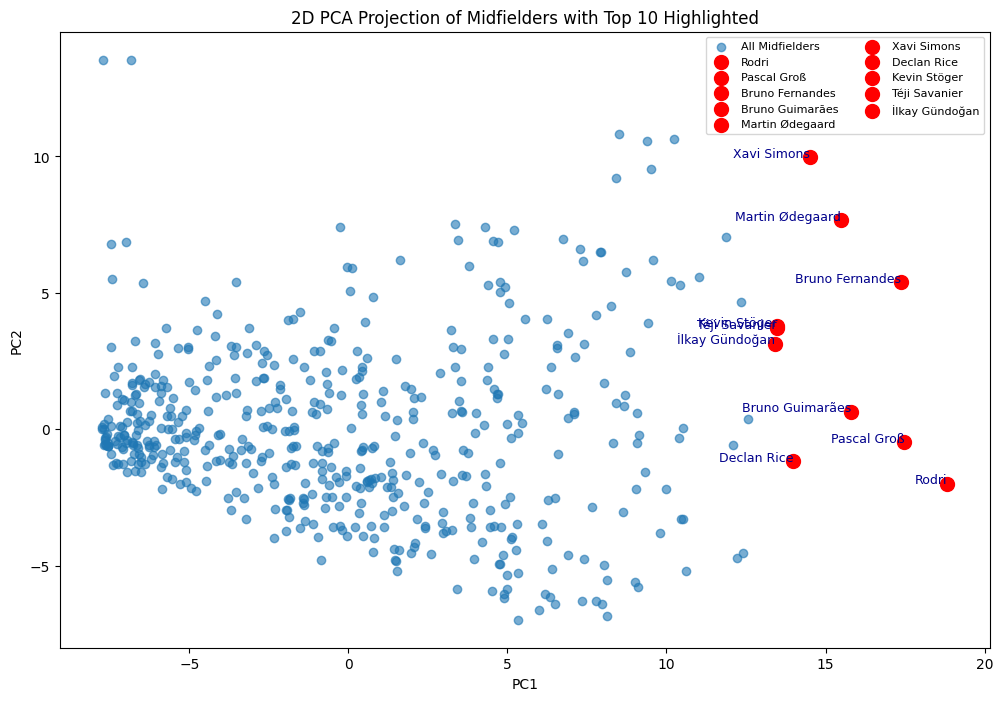

In [97]:
plt.figure(figsize=(12, 8))
plt.scatter(midfielder_train_pca[:, 0], midfielder_train_pca[:, 1], alpha=0.6, label="All Midfielders")

for _, row in top_midfielders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Midfielders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

This plot demonstrates that most of the midfielders are clustered near the center and spread outwards in both the PC1 and PC2 directions. The top 10 midfielders are on the outer side of the cluster on the positive axis of PC1 which indicates that their variance contributes heavily to PC1. 

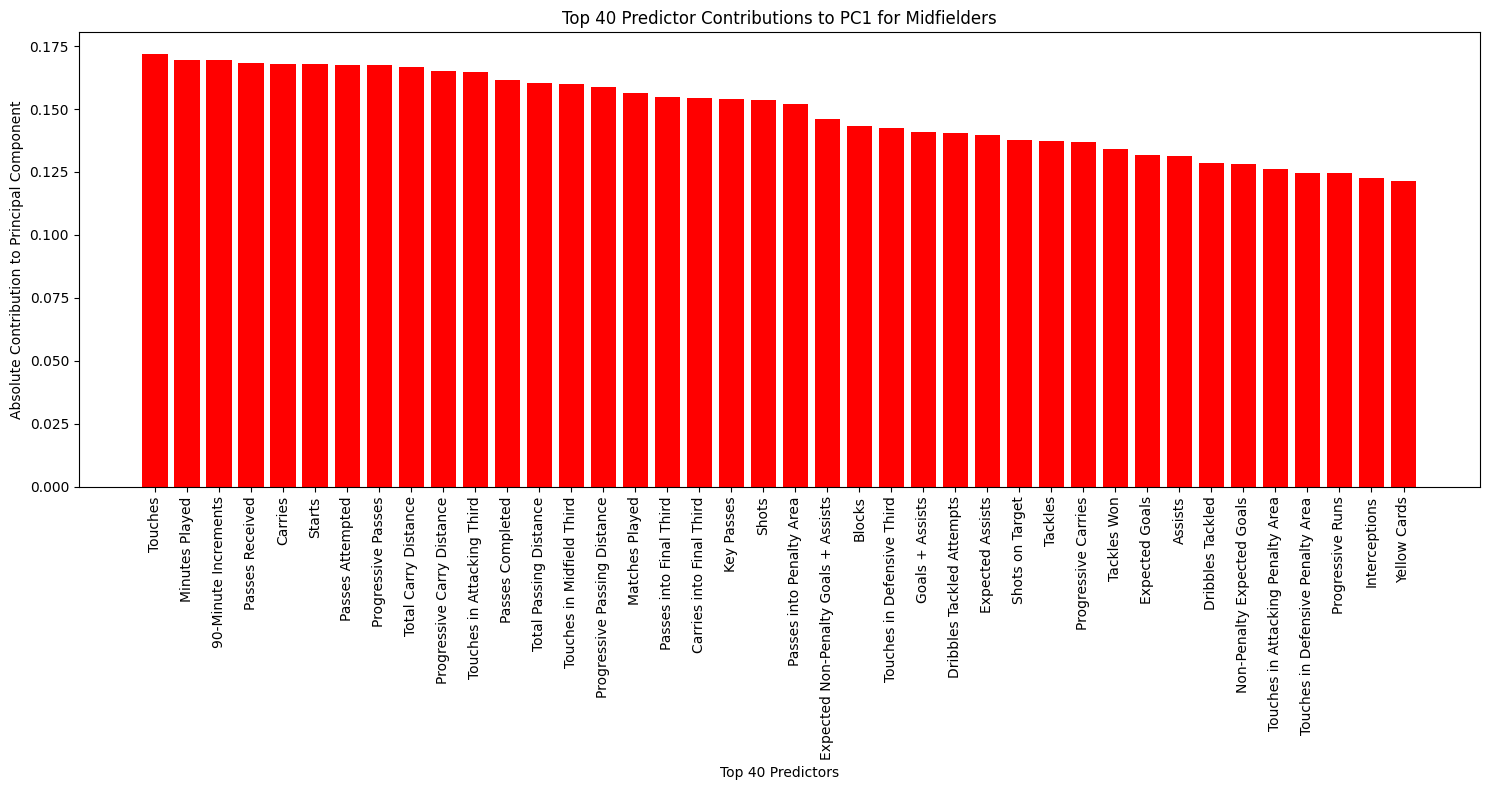

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
feature_names = midfielders.select_dtypes(include=[np.number]).columns
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = feature_names[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1 for Midfielders')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

Here, we can see the most important features of our first principal components. The top components are 'Touches', 'Minutes Played', '90 Minute Increments', and 'Passes Received'. This data is interesting because compared to defenders, there are a lot more skill specific features that contribute the most to PC1. It is also insightful for the specifics of the midfielder position because they have both defensive and offensive tasks within their positions. Midfielders appear to maintain a high level of involvement in the game, which is reflected by their the high correlation from the touches feature and the minutes played features. 

<a id="goalkeeper-pca"></a>

### <div class='subsection'>7.3 Goalkeeper Position PCA</div>

In this section, we split the goalkeeper data into training and testing data. Then we determine the number of principal components required to explain 95% of the variance. These principal components are what we will use in our base models. Then we project the data onto those principal components. We look at the top 10 goalkeepers based on the first principal component to check with online data and see how the top 10 players we see compared to the data online. Then we visualize the 2D PCA projection of all goalkeepers while highlighting the top 10 players. Then we analyze the top 40 predictor contributions to the first principal component to understand which features are determining the data we see. 

[Return to Section 8](#PCA)

The total number of components is: 19.
The number of components required to explain 95% of the variance is: 7.


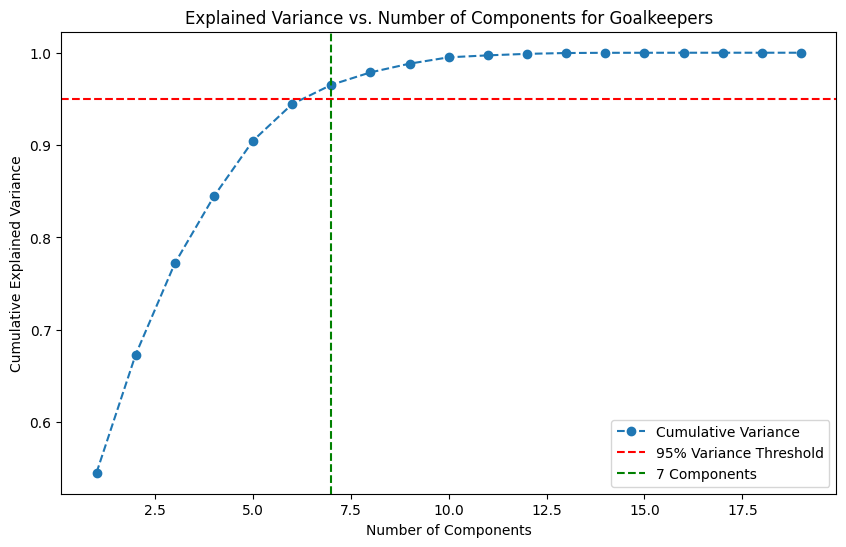

In [139]:
x_goalkeeper_train, x_goalkeeper_test, y_goalkeeper_train, y_goalkeeper_test = train_test_split(
    x_goalkeepers, y_goalkeepers, test_size=0.2, random_state=109
)

#apply pca to goalkeeper training and test data
pca = PCA()
goalkeeper_train_pca = pca.fit_transform(x_goalkeeper_train)
goalkeeper_test_pca = pca.transform(x_goalkeeper_test)

#calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

#find the number of components explaining 95% of variance
goalkeeper_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {goalkeeper_valid_components}.")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=goalkeeper_valid_components, color='g', linestyle='--', label=f'{goalkeeper_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Goalkeepers')
plt.legend(loc='best')
plt.show()

In [140]:
pca_95 = PCA(n_components=goalkeeper_valid_components)

#apply pca with valid components to training and test data
goalkeeper_train_pca_95 = pca_95.fit_transform(x_goalkeeper_train)
goalkeeper_test_pca_95 = pca_95.transform(x_goalkeeper_test)

#calculate explained variance for selected components
explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_95 = np.cumsum(explained_variance_ratio_95)

#split indices for linking players with pca results
x_goalkeeper_train_indices, x_goalkeeper_test_indices, y_goalkeeper_train, y_goalkeeper_test = train_test_split(
    goalkeepers.index, y_goalkeepers, test_size=0.2, random_state=109
)

#prepare training dataframe with pca components and player info
x_goalkeeper_train_df = pd.DataFrame(goalkeeper_train_pca_95, columns=[f"PC{i+1}" for i in range(goalkeeper_train_pca_95.shape[1])])
x_goalkeeper_train_df['Player'] = goalkeepers.iloc[x_goalkeeper_train_indices]['Player'].values

#prepare test dataframe with pca components and player info
x_goalkeeper_test_df = pd.DataFrame(goalkeeper_test_pca_95, columns=[f"PC{i+1}" for i in range(goalkeeper_test_pca_95.shape[1])])
x_goalkeeper_test_df['Player'] = goalkeepers.iloc[x_goalkeeper_test_indices]['Player'].values

#get top 10 goalkeepers based on the first principal component
top_goalkeepers = x_goalkeeper_train_df.nlargest(10, 'PC1')
print("Top 10 goalkeepers based on PC1:")
print(top_goalkeepers[['Player', 'PC1']])


Top 10 goalkeepers based on PC1:
                   Player    PC1
92            André Onana  5.486
54        Thomas Kaminski  5.046
132       Paulo Gazzaniga  4.972
28        Jordan Pickford  4.888
23                José Sá  4.798
131  Giorgi Mamardashvili  4.681
114            Bernd Leno  4.677
13         Oliver Baumann  4.675
116     Guglielmo Vicario  4.637
48      Alexandre Oukidja  4.570


We thought that this this information would be interesting to note so that when we did our later comparisons we could have another metric to use to compare models with each other. We also wanted to compare these results to our general knowledge of who we know some of the top goalkeepers in these to be.

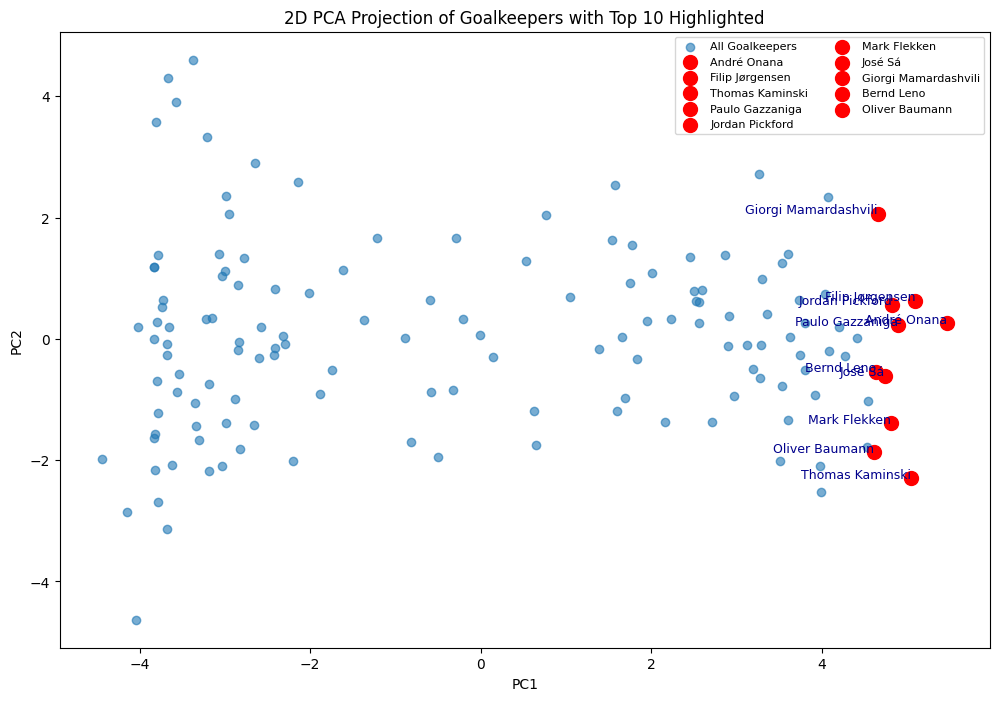

In [101]:
plt.figure(figsize=(12, 8))
plt.scatter(goalkeeper_train_pca[:, 0], goalkeeper_train_pca[:, 1], alpha=0.6, label="All Goalkeepers")

for _, row in top_goalkeepers.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeepers with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

In this graph, most of the goalkeepers are clustered toward the center of the plot. However, the top 10 goalkeepers are located toward the right of the plot on the positive PC1 axis. This indicates that the players' performance contributes significantly to the variance that is captured by PC1.

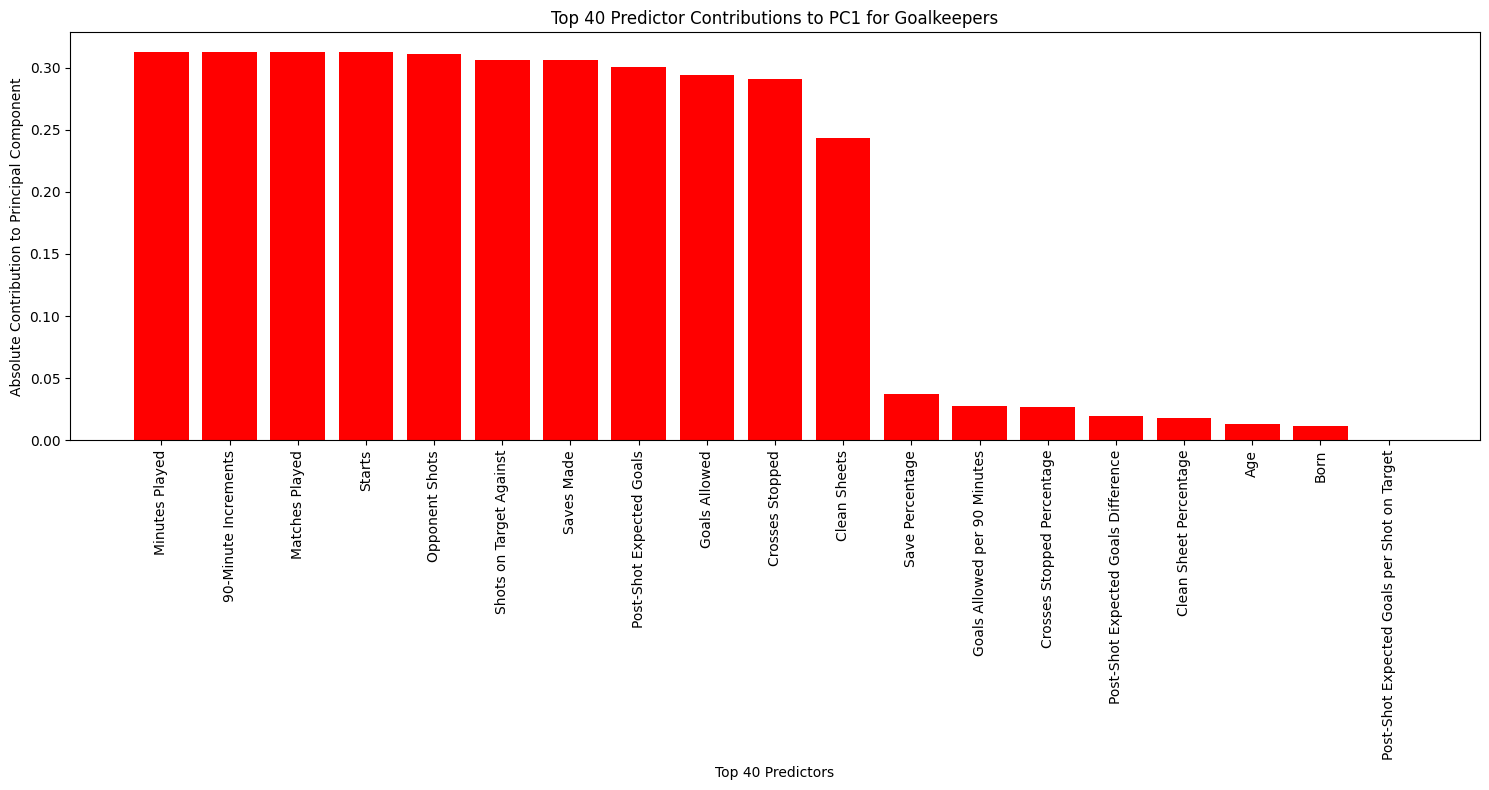

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
feature_names = goalkeepers.select_dtypes(include=[np.number]).columns
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = feature_names[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1 for Goalkeepers')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

Here, we can see the most important features of our first principal components for goalkeepers. The top components are 'Minutes Played', 'Matches Played', '90 Minute Increments', 'Starts', and 'Opponent Shots'. his data is interesting because it highlights some of the important roles of goalkeepers, where the consistent game time is a strong indicator of their reliability to the team and the opponent shots feature highlights their ability to handle the offensive pressures they face. Interestingly, the number of saves made is not as significant of a feature, which suggests that even though saves may be a crucial factor for the goalkeeper position, the goalkeeper's overall value may be more influenced by factors like reliability and their defensive actions rather than just their raw save numbers. 

<a id="forward-pca-2"></a>

### <div class='subsection'>7.4 Forward Position PCA</div>


In this section, we split the forward data into training and testing data. Then we determine the number of principal components required to explain 95% of the variance. These principal components are what we will use in our base models. Then we project the data onto those principal components. We look at the top 10 forwards based on the first principal component to check with online data and see how the top 10 players we see compared to the data online. Then we visualize the 2D PCA projection of all forwards while highlighting the top 10 players. Then we analyze the top 40 predictor contributions to the first principal component to understand which features are determining the data we see. 

[Return to Section 8](#PCA)

The total number of components is: 62.
The number of components required to explain 95% of the variance is: 17.


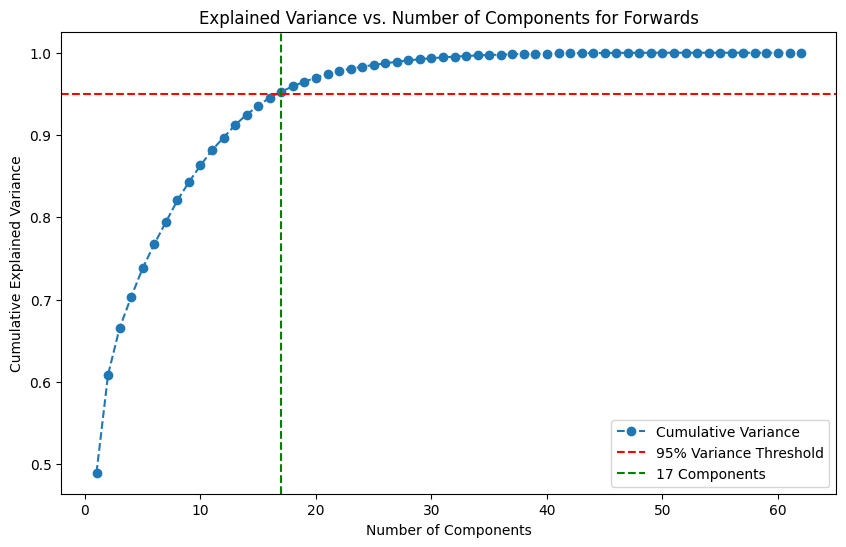

In [135]:
x_forward_train, x_forward_test, y_forward_train, y_forward_test = train_test_split(x_forwards, y_forwards, test_size=0.2, random_state=109)

#apply pca to forward training and test data
pca = PCA()
forward_train_pca = pca.fit_transform(x_forward_train)
forward_test_pca = pca.transform(x_forward_test)

#calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

#find the number of components explaining 95% of variance
forward_valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {forward_valid_components}.")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=forward_valid_components, color='g', linestyle='--', label=f'{forward_valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Forwards')
plt.legend(loc='best')
plt.show()


In [136]:
pca_95 = PCA(n_components=forward_valid_components)

#apply pca with valid components to training and test data
forward_train_pca_95 = pca_95.fit_transform(x_forward_train)
forward_test_pca_95 = pca_95.transform(x_forward_test)

#calculate explained variance for selected components
explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_95 = np.cumsum(explained_variance_ratio_95)

#split indices for linking players with pca results
x_forward_train_indices, x_forward_test_indices, y_forward_train, y_forward_test = train_test_split(
    forwards.index, y_forwards, test_size=0.2, random_state=109
)

#prepare training dataframe with pca components and player info
x_forward_train_df = pd.DataFrame(forward_train_pca_95, columns=[f"PC{i+1}" for i in range(forward_train_pca_95.shape[1])])
x_forward_train_df['Player'] = forwards.iloc[x_forward_train_indices]['Player'].values

#prepare test dataframe with pca components and player info
x_forward_test_df = pd.DataFrame(forward_test_pca_95, columns=[f"PC{i+1}" for i in range(forward_test_pca_95.shape[1])])
x_forward_test_df['Player'] = forwards.iloc[x_forward_test_indices]['Player'].values

#get top 10 forwards based on the first principal component
top_forwards = x_forward_train_df.nlargest(10, 'PC1')
print("Top 10 forwards based on PC1:")
print(top_forwards[['Player', 'PC1']])


Top 10 forwards based on PC1:
                  Player     PC1
150          Cole Palmer  17.941
162          Bukayo Saka  17.842
353           Phil Foden  16.855
385        Kylian Mbappé  14.907
240        Mohamed Salah  14.542
158  Romain Del Castillo  13.953
405        Chris Führich  13.239
267          Rafael Leão  13.199
87            Harry Kane  13.002
413           Leroy Sané  12.847


We thought that this this information would be interesting to note so that when we did our later comparisons we could have another metric to use to compare models with each other. We also wanted to compare these results to our general knowledge of who we know some of the top forwards in these to be.

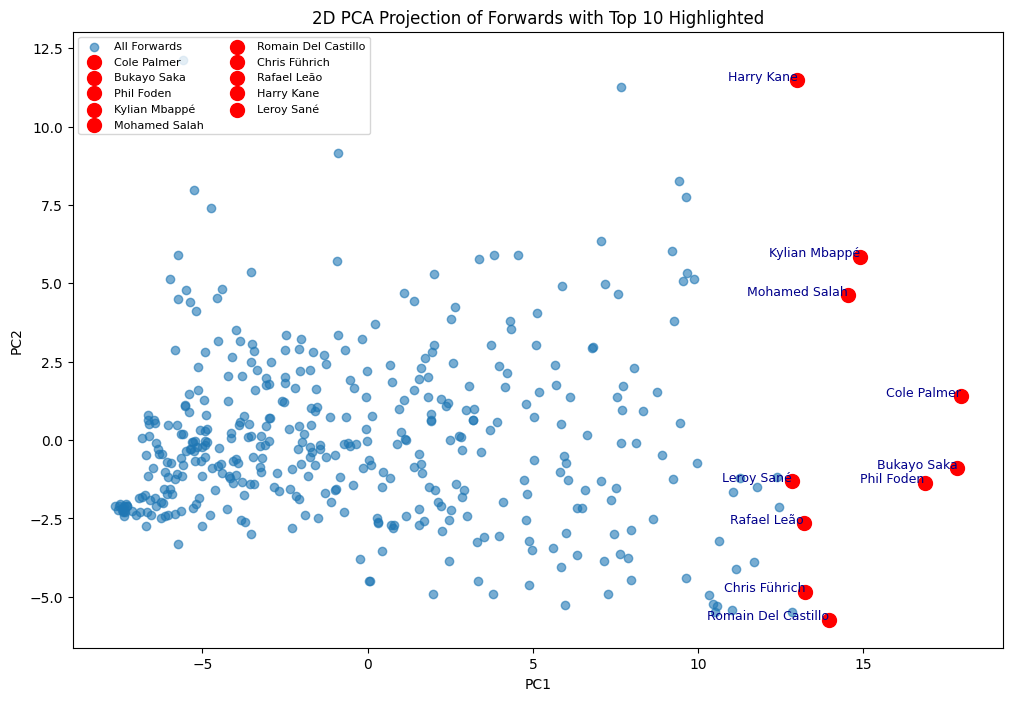

In [137]:
plt.figure(figsize=(12, 8))
plt.scatter(forward_train_pca[:, 0], forward_train_pca[:, 1], alpha=0.6, label="All Forwards")

for _, row in top_forwards.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Forwards with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

In this graph, most of the forwards clustered in the area with the lower PC1 and PC2 values which indivates that a lot of the forwards have similar performance metrics. However, the top 10 forwards are located toward the right of the plot on the positive PC1 axis. This indicates that the players' performance contributes significantly to the variance that is captured by PC1.

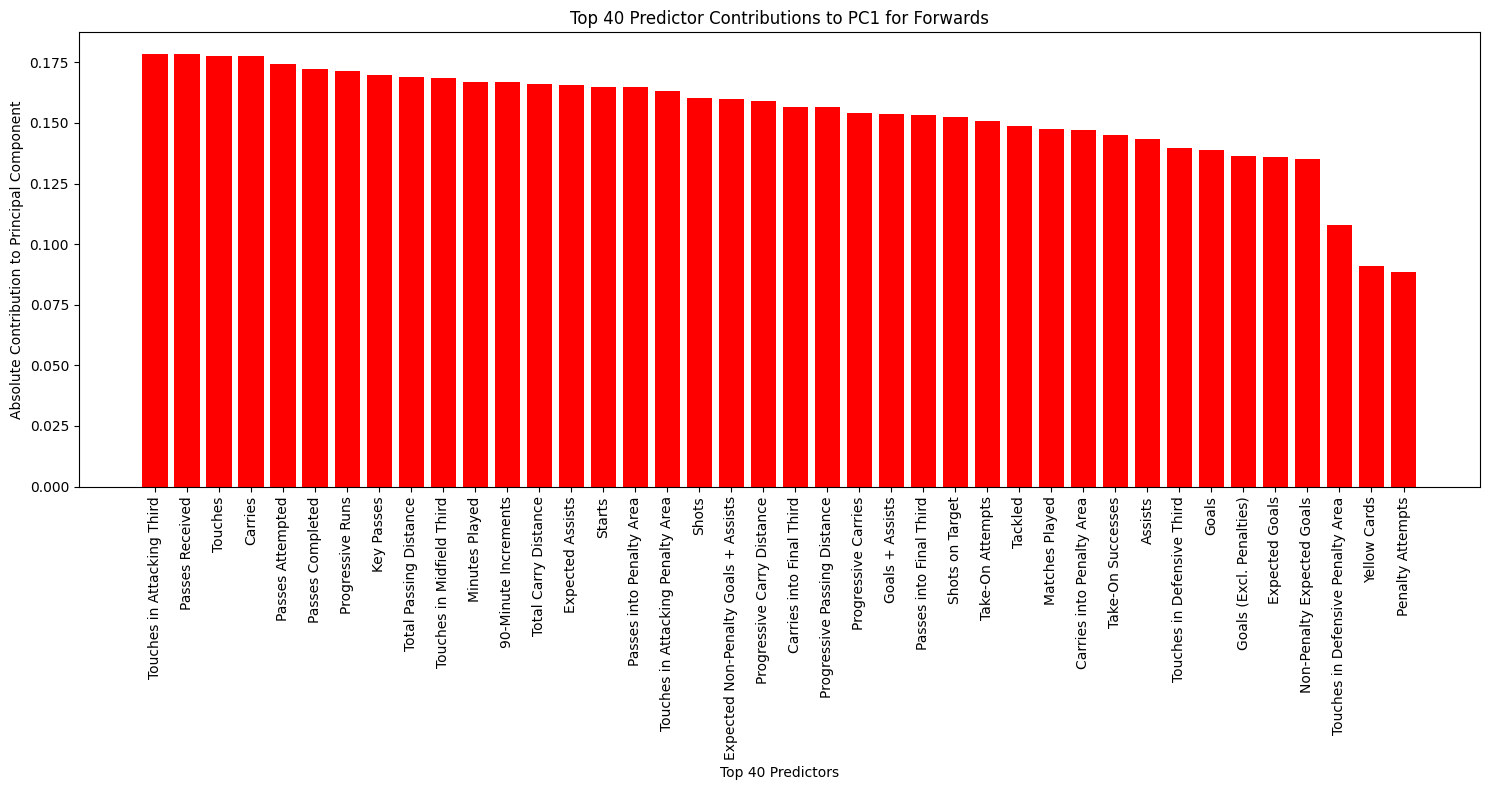

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
feature_names = forwards.select_dtypes(include=[np.number]).columns
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = feature_names[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1 for Forwards')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

Here, we can see the most important features of our first principal components for forwards. The top components are 'Passes Received', 'Touches in Attacking Third', 'Touches', and 'Carries'. This data is interesting because it highlights that the forwards position is very skill-based and also goal beyond just scoring goals. The 'Passes Received' and 'Touches in Attacking Third' features emphasize the importance of the forwards ability to create and capitalize on scoring opportunities. Additionally, the higher correlation of the 'Touches' and 'Carries' features reflect the importance of a forwards ability to maintain posession of the ball and progress ball in order to maintain offensive pressure and ultimately score goals. These findings overall suggest that the market value of forwards is strongly influenced by their contribution to the team's attackign strategies, and not just how many goals they score. 

<a id="baseline-models"></a>

## <div class='section'>Section 8: Baseline Modeling</div>

In this section, we apply Decision Tree models, Bagging Regression models, Linear Regression models, Random Forest models, Gradient Boosting models, and Mixture of Experts models to the principal components which explained 95% of the variance of each player position that was determined in the previous section. To evaluate the performance of each model, we calculate the R² values, Mean Squared Error (MSE) values, and Mean Absolute Error (MAE) values. The best model is determined based on the highest R² values and the lowest MAE and MSE values.

[Return to contents](#contents)


<a id="baseline-models-defender"></a>

## <div class='sub-section'>8.1: Defender Model Baselines 

### <a id="baseline-models-defense-dt"></a> 8.1.A Defender Decision Tree

Here we implement a Decision Tree Regressor using the PCA-transformed data. We evaluate the 'squared_error' and 'friedman_mse' splitting criteria across a range of tree depths (2-30) using 5-fold cross-validation in order to identify the combination with the highest R² score. Then the best-performing model is selected based on the cross-validation results and is evaluated on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data.

In [107]:
criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []

#loop through criteria and depths for cross-validation
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth + 1, step):
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth, random_state=109)
        
        scores = cross_val_score(dt, X=defender_train_pca, y=y_defender_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

#store results in a dataframe
df = pd.DataFrame(results)

#find the best parameters
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

#filter results by criteria
df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

#get the best depth for each criteria
best_depth_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'depth']
best_depth_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'depth']

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error', random_state=109)
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse', random_state=109)

#fit models using the best depths
model_tree_squared.fit(defender_train_pca, y_defender_train)
model_tree_friedman.fit(defender_train_pca, y_defender_train)

train_pred_squared = model_tree_squared.predict(defender_train_pca)
train_pred_friedman = model_tree_friedman.predict(defender_train_pca)

#compute R2 scores
r2_train_squared = r2_score(y_defender_train, train_pred_squared)
r2_train_friedman = r2_score(y_defender_train, train_pred_friedman)

cv_r2_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'mean_cv']
cv_r2_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'mean_cv']

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

#select the best model
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
    best_criterion = 'squared_error'
    best_depth = best_depth_squared
else:
    model = model_tree_friedman
    best_criterion = 'friedman_mse'
    best_depth = best_depth_friedman

pred = model.predict(defender_test_pca)

#transform predictions back to the original scale
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_defender_test)

#evaluate the final model on test data
test_r2 = r2_score(y_test_exp, pred_exp)
test_mse = mean_squared_error(y_test_exp, pred_exp)
test_mae = mean_absolute_error(y_test_exp, pred_exp)

print("\n================ [Best Decision Tree Model] ================")
print(f"Best Criterion: {best_criterion}")
print(f"Best Depth: {best_depth}")
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))

#create and display the results dataframe
defenders_results_df = pd.DataFrame(columns=['model', 'r2', 'mse', 'mae'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)



================ [Squared Error (Using PCA)] ================
Training R²: 0.5360
Cross-Validation R²: 0.2876

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.5360
Cross-Validation R²: 0.2876

================ [Best Decision Tree Model] ================
Best Criterion: squared_error
Best Depth: 4

Test R²: 0.2584
Test MSE: 161126055386790.1250
Test MAE: 7613676.2248


/var/folders/60/p096bbc123s8vdpcl13cnyt00000gn/T/ipykernel_76247/1478123657.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)


model     r2        mse        mae
0  Decision Tree  0.258  1.611e+14  7.614e+06

The regression results indicate that the decision tree model struggles to generalize beyond the training data. Although the training R² of approximately 0.54 suggests that the model captures some patterns within the training set, the cross-validation R² of around 0.29 shows a notable drop in performance, indicating overfitting. More concerning is the test R² of 0.26, which implies that the model's predictions are only marginally better than a simple baseline that always predicts the mean value. This poor generalization, combined with the elevated training scores and large errors (MSE: 1.61e+14, MAE: 7.61e+06), strongly suggests that the decision tree regressor in its current form is not well-suited for this market value prediction task. Further model refinement, such as hyperparameter tuning, additional feature engineering, or exploring alternative approaches like ensemble models, is necessary to achieve more reliable and meaningful results.

### <a id="baseline-models-defense-bagging"></a> 8.1.B Defender Bagging Model

Here, we implement a Bagging Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [108]:
bagging_defenders = BaggingRegressor(random_state=109, n_estimators=50)

bagging_defenders.fit(defender_train_pca, y_defender_train)

#predict on test data
y_pred_bagging = bagging_defenders.predict(defender_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_defender_test), np.expm1(y_pred_bagging))
mse = mean_squared_error(np.expm1(y_defender_test), np.expm1(y_pred_bagging))
mae = mean_absolute_error(np.expm1(y_defender_test), np.expm1(y_pred_bagging))

print("\nTest R² (Bagging): {:.4f}".format(r2))
print("Test MSE (Bagging): {:.4f}".format(mse))
print("Test MAE (Bagging): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)



Test R² (Bagging): 0.2750
Test MSE (Bagging): 157519281760247.5938
Test MAE (Bagging): 6832219.5540


model     r2        mse        mae
0             Decision Tree  0.258  1.611e+14  7.614e+06
1  Bagging (Decision Trees)  0.275  1.575e+14  6.832e+06

The results suggest that while decision trees can capture some variance in the training data, generalization to unseen data remains a challenge. Even after employing bagging, the test R² is only 0.296, indicating that the ensemble model explains limited variance in the test set. The MSE of approximately 1.53e+14 and MAE of 6.83e+06 further highlights the gap between training and testing performance, suggesting that these models, in their current configurations, have limited predictive power for this particular task and are overfitting.

### <a id="baseline-models-defense-logreg"></a> 8.1.C Defender Linear Regression Model

Here, we implement a Linear Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [109]:
lr = LinearRegression()
lr.fit(defender_train_pca, y_defender_train)

#predict on test data
pred = lr.predict(defender_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_defender_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_defender_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_defender_test), np.expm1(pred))

print("\nTest R² (Linear Regression): {:.4f}".format(r2))
print("Test MSE (Linear Regression): {:.4f}".format(mse))
print("Test MAE (Linear Regression): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)




Test R² (Linear Regression): 0.2130
Test MSE (Linear Regression): 170977096610854.5000
Test MAE (Linear Regression): 6830032.8728


model     r2        mse        mae
0             Decision Tree  0.258  1.611e+14  7.614e+06
1  Bagging (Decision Trees)  0.275  1.575e+14  6.832e+06
2                 LinearReg  0.213  1.710e+14  6.830e+06

The results suggest that the linear regression model performs worst than the decision tree and bagging models with a test R² of 0.213. These results also suggest that the simple linear models are not the best suited model for predicting market values for defenders.

### <a id="baseline-models-defense-rf"></a> 8.1.D Defender Random Forest Model

Here, we implement a Random Forest Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [110]:
rf_model = RandomForestRegressor(random_state=109, n_estimators=100)  
rf_model.fit(defender_train_pca, y_defender_train)

#predict on test data
pred = rf_model.predict(defender_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_defender_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_defender_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_defender_test), np.expm1(pred))

print("\nTest R² (Random Forest): {:.4f}".format(r2))
print("Test MSE (Random Forest): {:.4f}".format(mse))
print("Test MAE (Random Forest): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Random Forest'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)




Test R² (Random Forest): 0.2773
Test MSE (Random Forest): 157018414802875.8125
Test MAE (Random Forest): 6807854.5028


model     r2        mse        mae
0             Decision Tree  0.258  1.611e+14  7.614e+06
1  Bagging (Decision Trees)  0.275  1.575e+14  6.832e+06
2                 LinearReg  0.213  1.710e+14  6.830e+06
3             Random Forest  0.277  1.570e+14  6.808e+06

These results suggest the random forest model, with a test R² of 0.2835, performs slightly worse than the bagging model but better than  the Decision Tree (R² =  Linear Regression  models. This suggests that the ensemble methods, outperm the simpler models by campturing more variance and reducing the prediction errors. Further optimizations, like hyperparameter tuning, may be necessary to achieve better prediction accuracies.

### <a id="baseline-models-defense-gb"></a> 8.1.E Defender Gradient Boosting Forest Model

Here, we implement a Gradient Boosting Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [111]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(defender_train_pca, y_defender_train)

#predict on test data
pred = gb_model.predict(defender_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_defender_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_defender_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_defender_test), np.expm1(pred))

print("Baseline Gradient Boosting Results:")
print("\nTest R² (Gradient Boosting): {:.4f}".format(r2))
print("Test MSE (Gradient Boosting): {:.4f}".format(mse))
print("Test MAE (Gradient Boosting): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)


Baseline Gradient Boosting Results:

Test R² (Gradient Boosting): 0.3405
Test MSE (Gradient Boosting): 143283594825586.5000
Test MAE (Gradient Boosting): 6563059.6193


model     r2        mse        mae
0             Decision Tree  0.258  1.611e+14  7.614e+06
1  Bagging (Decision Trees)  0.275  1.575e+14  6.832e+06
2                 LinearReg  0.213  1.710e+14  6.830e+06
3             Random Forest  0.277  1.570e+14  6.808e+06
4         Gradient Boosting  0.341  1.433e+14  6.563e+06

These results suggest that the gradient boosting model outperforms all of the previous models with an R² of 0.3572. The MSE of  1.40e+14 and MAE of 6.53e+06 are also the lowest among the models. These results suggest that gradient boosting is the best suited for analyzing the patterns of the data. There is still room for improvement through hyper parameter tuning for this model.

### <a id="baseline-models-defense-mix"></a> 8.1.F Defender Mixture of Experts Model

Here, we implement a Mixture of Experts model to combine the predictions from the Gradient Boosting model (expert1) and Random Forest model (expert2), which are both trained on the PCA-transformed training data. During training, the predictions from the two expert models are compared to the actual target values in order to assign the gating label. A Logistic Regression gating network is trained to predict the expert weights on each sample. Then the predictions from both experts are combined for testing, and the final predictions are a weighted average of the two expert predictions. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [112]:
expert1 = gb_model
expert2 = rf_model

#fit both expert models on the PCA-transformed defender training data
expert1.fit(defender_train_pca, y_defender_train)
expert2.fit(defender_train_pca, y_defender_train)

#stack predictions from both experts for the training data
expert_preds_train = np.column_stack([
    expert1.predict(defender_train_pca),
    expert2.predict(defender_train_pca),
])

y_train_array = np.array(y_defender_train)

#assign gating labels based on the closest expert prediction
gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

#initialize and train the gating network
gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=109)
gating_network.fit(defender_train_pca, gating_labels)

#generate predictions from both experts for the test data
expert1_preds = expert1.predict(defender_test_pca)
expert2_preds = expert2.predict(defender_test_pca)

#compute gating weights for test data
gating_weights = gating_network.predict_proba(defender_test_pca)

#combine expert predictions using gating weights
final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

#transform predictions and true values from log scale
final_preds_exp = np.expm1(final_preds)
y_defender_test_exp = np.expm1(y_defender_test)

#evaluate the mixture of experts on the test data
r2 = r2_score(y_defender_test_exp, final_preds_exp)
mse = mean_squared_error(y_defender_test_exp, final_preds_exp)
mae = mean_absolute_error(y_defender_test_exp, final_preds_exp)

print("Mixture of Experts Results:")
print("\nTest R² (Mixture of Experts): {:.4f}".format(r2))
print("Test MSE (Mixture of Experts): {:.4f}".format(mse))
print("Test MAE (Mixture of Experts): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Mixture of Experts'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)


Mixture of Experts Results:

Test R² (Mixture of Experts): 0.3447
Test MSE (Mixture of Experts): 142373686157593.5000
Test MAE (Mixture of Experts): 6325285.8829


/Users/kemiokoye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2        mse        mae
0             Decision Tree  0.258  1.611e+14  7.614e+06
1  Bagging (Decision Trees)  0.275  1.575e+14  6.832e+06
2                 LinearReg  0.213  1.710e+14  6.830e+06
3             Random Forest  0.277  1.570e+14  6.808e+06
4         Gradient Boosting  0.341  1.433e+14  6.563e+06
5        Mixture of Experts  0.345  1.424e+14  6.325e+06

These results suggest that the mixture of experts model with a test R² of 0.352, which is slightly lower than Gradient Boosting (R² = 0.357) but still significantly better than Bagging and Random Forest. These results also indivate that combining the predictions from the two experts with a gating network allow the Mixture of Experts to use the strengths of both models. However, the underperformance relative to Gradient Boosting suggests that the gating network could use further tuning.

<a id="baseline-models-midfielder"></a>

## <div class='sub-section'>8.2: Midfielder Model Baselines 

### <a id="baseline-models-midfielder-dt"></a> 8.2.A Midfielder Decision Tree Baseline Model

Here we implement a Decision Tree Regressor using the PCA-transformed data. We evaluate the 'squared_error' and 'friedman_mse' splitting criteria across a range of tree depths (2-30) using 5-fold cross-validation in order to identify the combination with the highest R² score. Then the best-performing model is selected based on the cross-validation results and is evaluated on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [113]:
criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []

#loop through criteria and depths for cross-validation
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth + 1, step):
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth, random_state=109)
        
        scores = cross_val_score(dt, X=midfielder_train_pca, y=y_midfielder_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

df = pd.DataFrame(results)

#find the best parameters
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

#filter results by criteria
df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

#get the best depth for each criterion
best_depth_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'depth']
best_depth_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'depth']

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error', random_state=109)
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse', random_state=109)

#fit models using the best depths
model_tree_squared.fit(midfielder_train_pca, y_midfielder_train)
model_tree_friedman.fit(midfielder_train_pca, y_midfielder_train)

train_pred_squared = model_tree_squared.predict(midfielder_train_pca)
train_pred_friedman = model_tree_friedman.predict(midfielder_train_pca)

#compute training R2 scores
r2_train_squared = r2_score(y_midfielder_train, train_pred_squared)
r2_train_friedman = r2_score(y_midfielder_train, train_pred_friedman)

cv_r2_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'mean_cv']
cv_r2_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'mean_cv']

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

#select the best model
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
    best_criterion = 'squared_error'
    best_depth = best_depth_squared
else:
    model = model_tree_friedman
    best_criterion = 'friedman_mse'
    best_depth = best_depth_friedman

pred = model.predict(midfielder_test_pca)

#transform predictions back to the original scale
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_midfielder_test)

#evaluate the final model on test data
test_r2 = r2_score(y_test_exp, pred_exp)
test_mse = mean_squared_error(y_test_exp, pred_exp)
test_mae = mean_absolute_error(y_test_exp, pred_exp)

print("\n================ [Best Decision Tree Model] ================")
print(f"Best Criterion: {best_criterion}")
print(f"Best Depth: {best_depth}")
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))

#create and display the results dataframe
midfielders_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)



================ [Squared Error (Using PCA)] ================
Training R²: 0.4591
Cross-Validation R²: 0.2857

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.4591
Cross-Validation R²: 0.2857

================ [Best Decision Tree Model] ================
Best Criterion: squared_error
Best Depth: 3

Test R²: 0.2184
Test MSE: 483983206774141.9375
Test MAE: 10504613.6020


/var/folders/60/p096bbc123s8vdpcl13cnyt00000gn/T/ipykernel_76247/4257840698.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)


model     r2        mse        mae
0  Decision Tree  0.218  4.840e+14  1.050e+07

The midfielder model's performance metrics reveal a substantial discrepancy between training and evaluation phases, highlighting significant challenges in effectively predicting annual wages. With a training R² of approximately 0.29, the Decision Tree Regressor demonstrates a weak ability to explain the variance within the training dataset, suggesting that the model does not capture meaningful patterns from the training data. This performance translates to unseen data, as evidenced by the cross-validation R² values of around 0.1808 and a test R² of -0.06. The negative R² on the test set indicates that the model is performing worse than a simple baseline that always predicts the mean wage, underscoring severe prediction issues. Additionally, the test Mean Squared Error (MSE) of 0.484 further emphasizes the model's poor predictive accuracy.

### <a id="baseline-models-midfielder-bagging"></a> 8.2.B Midfielder Bagging Baseline Model

Here, we implement a Bagging Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [114]:
bagging_midfielders = BaggingRegressor(random_state=109, n_estimators=50)

bagging_midfielders.fit(midfielder_train_pca, y_midfielder_train)

#predict on test data
y_pred_bagging = bagging_midfielders.predict(midfielder_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_midfielder_test), np.expm1(y_pred_bagging))
mse = mean_squared_error(np.expm1(y_midfielder_test), np.expm1(y_pred_bagging))
mae = mean_absolute_error(np.expm1(y_midfielder_test), np.expm1(y_pred_bagging))

print("\nTest R² (Bagging): {:.4f}".format(r2))
print("Test MSE (Bagging): {:.4f}".format(mse))
print("Test MAE (Bagging): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)



Test R² (Bagging): 0.2502
Test MSE (Bagging): 464302077059472.6250
Test MAE (Bagging): 9123380.1413


model     r2        mse        mae
0             Decision Tree  0.218  4.840e+14  1.050e+07
1  Bagging (Decision Trees)  0.250  4.643e+14  9.123e+06

The decision tree performed worse for the midfielders than the defenders. The r^2 is negative, indicating that the model performs worse than a naive model.

### <a id="baseline-models-midfielder-logreg"></a> 8.2.C Midfielder Linear Regression Baseline Model

Here, we implement a Linear Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [115]:
lr = LinearRegression()
lr.fit(midfielder_train_pca, y_midfielder_train)

#predict continuous values
pred = lr.predict(midfielder_test_pca)

#compute regression metrics
r2 = r2_score(np.expm1(y_midfielder_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_midfielder_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_midfielder_test), np.expm1(pred))

print("\nTest R² (Linear Regression): {:.4f}".format(r2))
print("Test MSE (Linear Regression): {:.4f}".format(mse))
print("Test MAE (Linear Regression): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)



Test R² (Linear Regression): -3.3250
Test MSE (Linear Regression): 2678247237953488.0000
Test MAE (Linear Regression): 11747037.9816


model     r2        mse        mae
0             Decision Tree  0.218  4.840e+14  1.050e+07
1  Bagging (Decision Trees)  0.250  4.643e+14  9.123e+06
2                 LinearReg -3.325  2.678e+15  1.175e+07

### <a id="baseline-models-midfielder-rf"></a> 8.2.D Midfielder Random Forest Baseline Model

Here, we implement a Random Forest Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [116]:
rf_model = RandomForestRegressor(random_state=109, n_estimators=100)  
rf_model.fit(midfielder_train_pca, y_midfielder_train)

#predict on test data
pred = rf_model.predict(midfielder_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_midfielder_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_midfielder_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_midfielder_test), np.expm1(pred))

print("\nTest R² (Random Forest): {:.4f}".format(r2))
print("Test MSE (Random Forest): {:.4f}".format(mse))
print("Test MAE (Random Forest): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Random Forest'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)





Test R² (Random Forest): 0.2776
Test MSE (Random Forest): 447342297266857.0625
Test MAE (Random Forest): 8947901.6315


model     r2        mse        mae
0             Decision Tree  0.218  4.840e+14  1.050e+07
1  Bagging (Decision Trees)  0.250  4.643e+14  9.123e+06
2                 LinearReg -3.325  2.678e+15  1.175e+07
3             Random Forest  0.278  4.473e+14  8.948e+06

### <a id="baseline-models-midfielder-gradient"></a> 8.2.E Midfielder Gradient Boosting Baseline Model

Here, we implement a Gradient Boosting Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [117]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(midfielder_train_pca, y_midfielder_train)

#predict on test data
pred = gb_model.predict(midfielder_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_midfielder_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_midfielder_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_midfielder_test), np.expm1(pred))

print("Baseline Gradient Boosting Results:")
print("\nTest R² (Gradient Boosting): {:.4f}".format(r2))
print("Test MSE (Gradient Boosting): {:.4f}".format(mse))
print("Test MAE (Gradient Boosting): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)




Baseline Gradient Boosting Results:

Test R² (Gradient Boosting): 0.4315
Test MSE (Gradient Boosting): 352053019645714.5000
Test MAE (Gradient Boosting): 8123516.9943


model     r2        mse        mae
0             Decision Tree  0.218  4.840e+14  1.050e+07
1  Bagging (Decision Trees)  0.250  4.643e+14  9.123e+06
2                 LinearReg -3.325  2.678e+15  1.175e+07
3             Random Forest  0.278  4.473e+14  8.948e+06
4         Gradient Boosting  0.431  3.521e+14  8.124e+06

### <a id="baseline-models-midfielder-mix"></a> 8.2.F Midfielder Mixture of Experts Baseline Model

Here, we implement a Mixture of Experts model to combine the predictions from the Gradient Boosting model (expert1) and Random Forest model (expert2), which are both trained on the PCA-transformed training data. During training, the predictions from the two expert models are compared to the actual target values in order to assign the gating label. A Logistic Regression gating network is trained to predict the expert weights on each sample. Then the predictions from both experts are combined for testing, and the final predictions are a weighted average of the two expert predictions. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [118]:
expert1 = gb_model
expert2 = rf_model

#fit both expert models on the PCA-transformed midfielder training data
expert1.fit(midfielder_train_pca, y_midfielder_train)
expert2.fit(midfielder_train_pca, y_midfielder_train)

#stack predictions from both experts for the training data
expert_preds_train = np.column_stack([
    expert1.predict(midfielder_train_pca),
    expert2.predict(midfielder_train_pca),
])

y_train_array = np.array(y_midfielder_train)

#assign gating labels based on the closest expert prediction
gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

#initialize and train the gating network
gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=109)
gating_network.fit(midfielder_train_pca, gating_labels)

#generate predictions from both experts for the test data
expert1_preds = expert1.predict(midfielder_test_pca)
expert2_preds = expert2.predict(midfielder_test_pca)

#compute gating weights for test data
gating_weights = gating_network.predict_proba(midfielder_test_pca)

#combine expert predictions using gating weights
final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

#transform predictions and true values from log scale
final_preds_exp = np.expm1(final_preds)
y_midfielder_test_exp = np.expm1(y_midfielder_test)

#evaluate the mixture of experts on the test data
r2 = r2_score(y_midfielder_test_exp, final_preds_exp)
mse = mean_squared_error(y_midfielder_test_exp, final_preds_exp)
mae = mean_absolute_error(y_midfielder_test_exp, final_preds_exp)

print("Mixture of Experts Results:")
print("\nTest R² (Mixture of Experts): {:.4f}".format(r2))
print("Test MSE (Mixture of Experts): {:.4f}".format(mse))
print("Test MAE (Mixture of Experts): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Mixture of Experts'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)




Mixture of Experts Results:

Test R² (Mixture of Experts): 0.3411
Test MSE (Mixture of Experts): 408041783081216.1250
Test MAE (Mixture of Experts): 8577551.1626


/Users/kemiokoye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/kemiokoye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model     r2        mse        mae
0             Decision Tree  0.218  4.840e+14  1.050e+07
1  Bagging (Decision Trees)  0.250  4.643e+14  9.123e+06
2                 LinearReg -3.325  2.678e+15  1.175e+07
3             Random Forest  0.278  4.473e+14  8.948e+06
4         Gradient Boosting  0.431  3.521e+14  8.124e+06
5        Mixture of Experts  0.341  4.080e+14  8.578e+06

Similar to the defenders data set, logistic regression outperforms the decision tree in terms of various accuracy metrics, indicating it's strength as a model. 

<a id="baseline-models-goalkeeper"></a>

## <div class='sub-section'>8.3: Goalkeeper Model Baselines</div>



### <a id="baseline-models-goalkeeper-dt"></a> 8.3.A Goalkeeper Decision Tree Baseline Model

Here we implement a Decision Tree Regressor using the PCA-transformed data. We evaluate the 'squared_error' and 'friedman_mse' splitting criteria across a range of tree depths (2-30) using 5-fold cross-validation in order to identify the combination with the highest R² score. Then the best-performing model is selected based on the cross-validation results and is evaluated on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [119]:
criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []

#loop through criteria and depths for cross-validation
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth + 1, step):
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth, random_state=109)
        
        scores = cross_val_score(dt, X=goalkeeper_train_pca, y=y_goalkeeper_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

#store results in a dataframe
df = pd.DataFrame(results)

#find the best parameters
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

#filter results by criteria
df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

#get the best depth for each criteria
best_depth_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'depth']
best_depth_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'depth']

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error', random_state=109)
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse', random_state=109)

#fit models using the best depths
model_tree_squared.fit(goalkeeper_train_pca, y_goalkeeper_train)
model_tree_friedman.fit(goalkeeper_train_pca, y_goalkeeper_train)

train_pred_squared = model_tree_squared.predict(goalkeeper_train_pca)
train_pred_friedman = model_tree_friedman.predict(goalkeeper_train_pca)

#compute R2 scores
r2_train_squared = r2_score(y_goalkeeper_train, train_pred_squared)
r2_train_friedman = r2_score(y_goalkeeper_train, train_pred_friedman)


cv_r2_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'mean_cv']
cv_r2_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'mean_cv']

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

#select the best model
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
    best_criterion = 'squared_error'
    best_depth = best_depth_squared
else:
    model = model_tree_friedman
    best_criterion = 'friedman_mse'
    best_depth = best_depth_friedman

pred = model.predict(goalkeeper_test_pca)

#transform predictions back to the original scale
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_goalkeeper_test)

#evaluate the final model on test data
test_r2 = r2_score(y_test_exp, pred_exp)
test_mse = mean_squared_error(y_test_exp, pred_exp)
test_mae = mean_absolute_error(y_test_exp, pred_exp)

print("\n================ [Best Decision Tree Model] ================")
print(f"Best Criterion: {best_criterion}")
print(f"Best Depth: {best_depth}")
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))

#create and display the results dataframe
goalkeepers_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)



================ [Squared Error (Using PCA)] ================
Training R²: 0.5902
Cross-Validation R²: 0.1920

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.5902
Cross-Validation R²: 0.1920

================ [Best Decision Tree Model] ================
Best Criterion: squared_error
Best Depth: 2

Test R²: 0.3337
Test MSE: 42500279174880.1562
Test MAE: 3730911.7824


/var/folders/60/p096bbc123s8vdpcl13cnyt00000gn/T/ipykernel_76247/453284917.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)


model     r2        mse        mae
0  Decision Tree  0.334  4.250e+13  3.731e+06

The Decision Tree model’s performance metrics reveal that the learned patterns do not generalize well. Although the training R² is around 0.231, indicating that the model captures some variance in the training data, but barely performs better than a naive model (r^2 of 0). The substantial drop from training to cross-validation (and later to test) underscores severe overfitting and suggests that the model is not reliably capturing the underlying relationships necessary to predict goalkeeper wages. The test MSE of approximately 2.39 further supports the notion that the current model configuration is far from satisfactory, and that more robust feature engineering, hyperparameter tuning, or entirely different modeling approaches may be necessary.

### <a id="baseline-models-goalkeeper-bagging"></a> 8.3.B Goalkeeper Bagging Baseline Model

Here, we implement a Bagging Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [120]:
bagging_goalkeepers = BaggingRegressor(random_state=109, n_estimators=50)

bagging_goalkeepers.fit(goalkeeper_train_pca, y_goalkeeper_train)

#predict on test data
y_pred_bagging = bagging_goalkeepers.predict(goalkeeper_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_goalkeeper_test), np.expm1(y_pred_bagging))
mse = mean_squared_error(np.expm1(y_goalkeeper_test), np.expm1(y_pred_bagging))
mae = mean_absolute_error(np.expm1(y_goalkeeper_test), np.expm1(y_pred_bagging))

print("\nTest R² (Bagging): {:.4f}".format(r2))
print("Test MSE (Bagging): {:.4f}".format(mse))
print("Test MAE (Bagging): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)



Test R² (Bagging): 0.3160
Test MSE (Bagging): 43632769970730.3750
Test MAE (Bagging): 3720717.1570


model     r2        mse        mae
0             Decision Tree  0.334  4.250e+13  3.731e+06
1  Bagging (Decision Trees)  0.316  4.363e+13  3.721e+06

The bagging model performs very well on the goalkeeper data relative to the decision tree model.

### <a id="baseline-models-goalkeeper-logreg"></a> 8.3.C Goalkeeper Linear Regression Baseline Model

Here, we implement a Linear Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [121]:
lr = LinearRegression()
lr.fit(goalkeeper_train_pca, y_goalkeeper_train)

#predict continuous values
pred = lr.predict(goalkeeper_test_pca)

#compute regression metrics
r2 = r2_score(np.expm1(y_goalkeeper_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_goalkeeper_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_goalkeeper_test), np.expm1(pred))

print("\nTest R² (Linear Regression): {:.4f}".format(r2))
print("Test MSE (Linear Regression): {:.4f}".format(mse))
print("Test MAE (Linear Regression): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)



Test R² (Linear Regression): 0.2479
Test MSE (Linear Regression): 47977324416176.4688
Test MAE (Linear Regression): 4103342.0629


model     r2        mse        mae
0             Decision Tree  0.334  4.250e+13  3.731e+06
1  Bagging (Decision Trees)  0.316  4.363e+13  3.721e+06
2                 LinearReg  0.248  4.798e+13  4.103e+06

### <a id="baseline-models-goalkeeper-rf"></a> 8.3.D Goalkeeper Random Forest Baseline Model

Here, we implement a Random Forest Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [122]:
rf_model = RandomForestRegressor(random_state=109, n_estimators=100)  
rf_model.fit(goalkeeper_train_pca, y_goalkeeper_train)

#predict on test data
pred = rf_model.predict(goalkeeper_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_goalkeeper_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_goalkeeper_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_goalkeeper_test), np.expm1(pred))

print("\nTest R² (Random Forest): {:.4f}".format(r2))
print("Test MSE (Random Forest): {:.4f}".format(mse))
print("Test MAE (Random Forest): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Random Forest'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)





Test R² (Random Forest): 0.4004
Test MSE (Random Forest): 38245668527802.6562
Test MAE (Random Forest): 3433782.8720


model     r2        mse        mae
0             Decision Tree  0.334  4.250e+13  3.731e+06
1  Bagging (Decision Trees)  0.316  4.363e+13  3.721e+06
2                 LinearReg  0.248  4.798e+13  4.103e+06
3             Random Forest  0.400  3.825e+13  3.434e+06

### <a id="baseline-models-goalkeeper-gb"></a> 8.3.E Goalkeeper Gradient Boosting Baseline Model

Here, we implement a Gradient Boosting Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [123]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(goalkeeper_train_pca, y_goalkeeper_train)

#predict on test data
pred = gb_model.predict(goalkeeper_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_goalkeeper_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_goalkeeper_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_goalkeeper_test), np.expm1(pred))

print("Baseline Gradient Boosting Results:")
print("\nTest R² (Gradient Boosting): {:.4f}".format(r2))
print("Test MSE (Gradient Boosting): {:.4f}".format(mse))
print("Test MAE (Gradient Boosting): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)



Baseline Gradient Boosting Results:

Test R² (Gradient Boosting): 0.4066
Test MSE (Gradient Boosting): 37854614884889.4453
Test MAE (Gradient Boosting): 3473671.9112


model     r2        mse        mae
0             Decision Tree  0.334  4.250e+13  3.731e+06
1  Bagging (Decision Trees)  0.316  4.363e+13  3.721e+06
2                 LinearReg  0.248  4.798e+13  4.103e+06
3             Random Forest  0.400  3.825e+13  3.434e+06
4         Gradient Boosting  0.407  3.785e+13  3.474e+06

### <a id="baseline-models-goalkeeper-mix"></a> 8.3.F Goalkeeper Mixture of Experts Baseline Model

Here, we implement a Mixture of Experts model to combine the predictions from the Gradient Boosting model (expert1) and Random Forest model (expert2), which are both trained on the PCA-transformed training data. During training, the predictions from the two expert models are compared to the actual target values in order to assign the gating label. A Logistic Regression gating network is trained to predict the expert weights on each sample. Then the predictions from both experts are combined for testing, and the final predictions are a weighted average of the two expert predictions. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [124]:
expert1 = gb_model
expert2 = rf_model

#fit both expert models on the PCA-transformed goalkeeper training data
expert1.fit(goalkeeper_train_pca, y_goalkeeper_train)
expert2.fit(goalkeeper_train_pca, y_goalkeeper_train)

#stack predictions from both experts for the training data
expert_preds_train = np.column_stack([
    expert1.predict(goalkeeper_train_pca),
    expert2.predict(goalkeeper_train_pca),
])

y_train_array = np.array(y_goalkeeper_train)

#assign gating labels based on the closest expert prediction
gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

#initialize and train the gating network
gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=109)
gating_network.fit(goalkeeper_train_pca, gating_labels)

#generate predictions from both experts for the test data
expert1_preds = expert1.predict(goalkeeper_test_pca)
expert2_preds = expert2.predict(goalkeeper_test_pca)

#compute gating weights for test data
gating_weights = gating_network.predict_proba(goalkeeper_test_pca)

#combine expert predictions using gating weights
final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

#transform predictions and true values from log scale
final_preds_exp = np.expm1(final_preds)
y_goalkeeper_test_exp = np.expm1(y_goalkeeper_test)

#evaluate the mixture of experts on the test data
r2 = r2_score(y_goalkeeper_test_exp, final_preds_exp)
mse = mean_squared_error(y_goalkeeper_test_exp, final_preds_exp)
mae = mean_absolute_error(y_goalkeeper_test_exp, final_preds_exp)

print("Mixture of Experts Results:")
print("\nTest R² (Mixture of Experts): {:.4f}".format(r2))
print("Test MSE (Mixture of Experts): {:.4f}".format(mse))
print("Test MAE (Mixture of Experts): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Mixture of Experts'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)



Mixture of Experts Results:

Test R² (Mixture of Experts): 0.4082
Test MSE (Mixture of Experts): 37749534745836.8828
Test MAE (Mixture of Experts): 3434749.0000


/Users/kemiokoye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2        mse        mae
0             Decision Tree  0.334  4.250e+13  3.731e+06
1  Bagging (Decision Trees)  0.316  4.363e+13  3.721e+06
2                 LinearReg  0.248  4.798e+13  4.103e+06
3             Random Forest  0.400  3.825e+13  3.434e+06
4         Gradient Boosting  0.407  3.785e+13  3.474e+06
5        Mixture of Experts  0.408  3.775e+13  3.435e+06

It appears that the random forest model is the best model for the goalkeeper data thus far although it still has a lot of room for improvement given it's very low r2 score. The bagging model is next best with a higher MSE and a lower r2 score than the RF model. The linear regression model is the worst model, having the lowest r2 score.

<a id="baseline-models-forward"></a>

## <div class='sub-section'>8.4: Forward Model Baselines</div>


### <a id="baseline-models-forward-dt"></a> 8.4.A Forward Decision Tree Baseline Model

Here we implement a Decision Tree Regressor using the PCA-transformed data. We evaluate the 'squared_error' and 'friedman_mse' splitting criteria across a range of tree depths (2-30) using 5-fold cross-validation in order to identify the combination with the highest R² score. Then the best-performing model is selected based on the cross-validation results and is evaluated on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [125]:
criterion = ['squared_error', 'friedman_mse']
first_depth = 2
final_depth = 30
step = 1

results = []

#loop through criteria and depths for cross-validation
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth + 1, step):
        dt = DecisionTreeRegressor(criterion=cur_criterion, max_depth=max_depth, random_state=109)
        
        scores = cross_val_score(dt, X=forward_train_pca, y=y_forward_train, cv=5, n_jobs=-1, scoring='r2')
        
        cur_results = {
            'criterion': cur_criterion,
            'depth': max_depth,
            'all_cv': scores,
            'mean_cv': scores.mean()
        }
        results.append(cur_results)

#store results in a dataframe
df = pd.DataFrame(results)

#find the best parameters
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

#filter results by criteria
df_squared = df[df['criterion'] == 'squared_error']
df_friedman = df[df['criterion'] == 'friedman_mse']

#get the best depth for each criterion
best_depth_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'depth']
best_depth_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'depth']

model_tree_squared = DecisionTreeRegressor(max_depth=int(best_depth_squared), criterion='squared_error', random_state=109)
model_tree_friedman = DecisionTreeRegressor(max_depth=int(best_depth_friedman), criterion='friedman_mse', random_state=109)

#fit models using the best depths
model_tree_squared.fit(forward_train_pca, y_forward_train)
model_tree_friedman.fit(forward_train_pca, y_forward_train)

train_pred_squared = model_tree_squared.predict(forward_train_pca)
train_pred_friedman = model_tree_friedman.predict(forward_train_pca)

#compute R2 scores
r2_train_squared = r2_score(y_forward_train, train_pred_squared)
r2_train_friedman = r2_score(y_forward_train, train_pred_friedman)

cv_r2_squared = df_squared.loc[df_squared['mean_cv'].idxmax(), 'mean_cv']
cv_r2_friedman = df_friedman.loc[df_friedman['mean_cv'].idxmax(), 'mean_cv']

print("================ [Squared Error (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_squared))
print("Cross-Validation R²: {:.4f}".format(cv_r2_squared))

print("\n================ [Friedman MSE (Using PCA)] ================")
print("Training R²: {:.4f}".format(r2_train_friedman))
print("Cross-Validation R²: {:.4f}".format(cv_r2_friedman))

#select the best model
if cv_r2_squared >= cv_r2_friedman:
    model = model_tree_squared
    best_criterion = 'squared_error'
    best_depth = best_depth_squared
else:
    model = model_tree_friedman
    best_criterion = 'friedman_mse'
    best_depth = best_depth_friedman

pred = model.predict(forward_test_pca)

#transform predictions back to the original scale
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_forward_test)

#evaluate the final model on test data
test_r2 = r2_score(y_test_exp, pred_exp)
test_mse = mean_squared_error(y_test_exp, pred_exp)
test_mae = mean_absolute_error(y_test_exp, pred_exp)

print("\n================ [Best Decision Tree Model] ================")
print(f"Best Criterion: {best_criterion}")
print(f"Best Depth: {best_depth}")
print("\nTest R²: {:.4f}".format(test_r2))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))

#create and display the results dataframe
forwards_results_df = pd.DataFrame(columns=['model', 'r2', 'mse'])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)



================ [Squared Error (Using PCA)] ================
Training R²: 0.5243
Cross-Validation R²: 0.3375

================ [Friedman MSE (Using PCA)] ================
Training R²: 0.5243
Cross-Validation R²: 0.3375

================ [Best Decision Tree Model] ================
Best Criterion: squared_error
Best Depth: 3

Test R²: 0.1688
Test MSE: 304657455580353.2500
Test MAE: 9105522.8397


/var/folders/60/p096bbc123s8vdpcl13cnyt00000gn/T/ipykernel_76247/3868385577.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)


model     r2        mse        mae
0  Decision Tree  0.169  3.047e+14  9.106e+06

The decision tree model’s performance metrics indicate significant challenges in capturing and generalizing the underlying patterns necessary for accurate wage prediction. With a training R² of approximately 0.59, the Decision Tree Regressor demonstrates a moderate ability to explain the variance within the training dataset. However, this promising performance sharply declines during cross-validation, where the R² plummets to -1.19, and further deteriorates on the test set with an R² of -0.19. Negative R² values in both cross-validation and testing phases signify that the model performs worse than a naive baseline that simply predicts the mean wage, highlighting severe overfitting issues. Additionally, the test Mean Squared Error (MSE) of 1.06 underscores the model's poor predictive accuracy.

### <a id="baseline-models-forward-bagging"></a> 8.4.B Forward Bagging Baseline Model

Here, we implement a Bagging Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [126]:
bagging_forwards = BaggingRegressor(random_state=109, n_estimators=50)

bagging_forwards.fit(forward_train_pca, y_forward_train)

#predict on test data
y_pred_bagging = bagging_forwards.predict(forward_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_forward_test), np.expm1(y_pred_bagging))
mse = mean_squared_error(np.expm1(y_forward_test), np.expm1(y_pred_bagging))
mae = mean_absolute_error(np.expm1(y_forward_test), np.expm1(y_pred_bagging))

print("\nTest R² (Bagging): {:.4f}".format(r2))
print("Test MSE (Bagging): {:.4f}".format(mse))
print("Test MAE (Bagging): {:.4f}".format(mae))

#add results to dataframe
new_row = pd.DataFrame({
    'model': ['Bagging (Decision Trees)'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)




Test R² (Bagging): 0.2354
Test MSE (Bagging): 280252264869388.2500
Test MAE (Bagging): 8172749.4347


model     r2        mse        mae
0             Decision Tree  0.169  3.047e+14  9.106e+06
1  Bagging (Decision Trees)  0.235  2.803e+14  8.173e+06

The bagging model is worse all around than the decision tree model.

### <a id="baseline-models-forward-logreg"></a> 8.4.C Forward Linear Regression Baseline Model

Here, we implement a Linear Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [127]:
lr = LinearRegression()
lr.fit(forward_train_pca, y_forward_train)

#predict on test data
pred = lr.predict(forward_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_forward_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_forward_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_forward_test), np.expm1(pred))

print("\nTest R² (Linear Regression): {:.4f}".format(r2))
print("Test MSE (Linear Regression): {:.4f}".format(mse))
print("Test MAE (Linear Regression): {:.4f}".format(mae))

#add results to dataframe
new_row = pd.DataFrame({
    'model': ['LinearReg'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)



Test R² (Linear Regression): 0.1485
Test MSE (Linear Regression): 312106203683083.1875
Test MAE (Linear Regression): 7707321.0602


model     r2        mse        mae
0             Decision Tree  0.169  3.047e+14  9.106e+06
1  Bagging (Decision Trees)  0.235  2.803e+14  8.173e+06
2                 LinearReg  0.148  3.121e+14  7.707e+06

### <a id="baseline-models-forward-rf"></a> 8.4.D Forward Random Forest Baseline Model

Here, we implement a Random Forest Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [128]:
rf_model = RandomForestRegressor(random_state=109, n_estimators=100)  
rf_model.fit(forward_train_pca, y_forward_train)

#predict on test data
pred = rf_model.predict(forward_test_pca)

#evaluate predictions
r2 = r2_score(np.expm1(y_forward_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_forward_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_forward_test), np.expm1(pred))

print("\nTest R² (Random Forest): {:.4f}".format(r2))
print("Test MSE (Random Forest): {:.4f}".format(mse))
print("Test MAE (Random Forest): {:.4f}".format(mae))

#add results to dataframe
new_row = pd.DataFrame({
    'model': ['Random Forest'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)




Test R² (Random Forest): 0.2666
Test MSE (Random Forest): 268802899236172.0625
Test MAE (Random Forest): 8122255.0256


model     r2        mse        mae
0             Decision Tree  0.169  3.047e+14  9.106e+06
1  Bagging (Decision Trees)  0.235  2.803e+14  8.173e+06
2                 LinearReg  0.148  3.121e+14  7.707e+06
3             Random Forest  0.267  2.688e+14  8.122e+06

### <a id="baseline-models-forward-gb"></a> 8.4.E Forward Gradient Boosting Baseline Model

Here, we implement a Gradient Boosting Regressor to predict the market values for defenders based on their PCA-transformed features. Then the predictions were made on the test set. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [129]:
gb_model = GradientBoostingRegressor(random_state=109, n_estimators=100)  
gb_model.fit(forward_train_pca, y_forward_train)

#predict on test data
pred = gb_model.predict(forward_test_pca)

#calculate evaluation metrics
r2 = r2_score(np.expm1(y_forward_test), np.expm1(pred))
mse = mean_squared_error(np.expm1(y_forward_test), np.expm1(pred))
mae = mean_absolute_error(np.expm1(y_forward_test), np.expm1(pred))

print("Baseline Gradient Boosting Results:")
print("\nTest R² (Gradient Boosting): {:.4f}".format(r2))
print("Test MSE (Gradient Boosting): {:.4f}".format(mse))
print("Test MAE (Gradient Boosting): {:.4f}".format(mae))

#append results to the dataframe
new_row = pd.DataFrame({
    'model': ['Gradient Boosting'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)



Baseline Gradient Boosting Results:

Test R² (Gradient Boosting): 0.2335
Test MSE (Gradient Boosting): 280938193355405.1562
Test MAE (Gradient Boosting): 8212507.1766


model     r2        mse        mae
0             Decision Tree  0.169  3.047e+14  9.106e+06
1  Bagging (Decision Trees)  0.235  2.803e+14  8.173e+06
2                 LinearReg  0.148  3.121e+14  7.707e+06
3             Random Forest  0.267  2.688e+14  8.122e+06
4         Gradient Boosting  0.234  2.809e+14  8.213e+06

### <a id="baseline-models-forward-mix"></a> 8.4.F Forward Mixture of Experts Baseline Model

Here, we implement a Mixture of Experts model to combine the predictions from the Gradient Boosting model (expert1) and Random Forest model (expert2), which are both trained on the PCA-transformed training data. During training, the predictions from the two expert models are compared to the actual target values in order to assign the gating label. A Logistic Regression gating network is trained to predict the expert weights on each sample. Then the predictions from both experts are combined for testing, and the final predictions are a weighted average of the two expert predictions. To evaluate the performance, we calculate the R², MSE, and MAE values to add to a data frame in which we will compare the scores of all models we use to train and test the defender data. 

In [130]:
expert1 = gb_model
expert2 = rf_model

#fit both expert models on the PCA-transformed forward training data
expert1.fit(forward_train_pca, y_forward_train)
expert2.fit(forward_train_pca, y_forward_train)

#stack predictions from both experts for the training data
expert_preds_train = np.column_stack([
    expert1.predict(forward_train_pca),
    expert2.predict(forward_train_pca),
])

y_train_array = np.array(y_forward_train)

#assign gating labels based on the closest expert prediction
gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

#initialize and train the gating network
gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=109)
gating_network.fit(forward_train_pca, gating_labels)

#generate predictions from both experts for the test data
expert1_preds = expert1.predict(forward_test_pca)
expert2_preds = expert2.predict(forward_test_pca)

#compute gating weights for test data
gating_weights = gating_network.predict_proba(forward_test_pca)

#combine expert predictions using gating weights
final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

#back-transform predictions and true values from log scale
final_preds_exp = np.expm1(final_preds)
y_forward_test_exp = np.expm1(y_forward_test)

#evaluate the mixture of experts on the test data
r2 = r2_score(y_forward_test_exp, final_preds_exp)
mse = mean_squared_error(y_forward_test_exp, final_preds_exp)
mae = mean_absolute_error(y_forward_test_exp, final_preds_exp)

print("Mixture of Experts Results:")
print("\nTest R² (Mixture of Experts): {:.4f}".format(r2))
print("Test MSE (Mixture of Experts): {:.4f}".format(mse))
print("Test MAE (Mixture of Experts): {:.4f}".format(mae))

#add model results to the dataframe
new_row = pd.DataFrame({
    'model': ['Mixture of Experts'],  
    'r2': [round(r2, 4)],
    'mse': [round(mse, 4)],
    'mae': [round(mae, 4)]
})
forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)



Mixture of Experts Results:

Test R² (Mixture of Experts): 0.2706
Test MSE (Mixture of Experts): 267338673094870.0625
Test MAE (Mixture of Experts): 8062258.8205


/Users/kemiokoye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2        mse        mae
0             Decision Tree  0.169  3.047e+14  9.106e+06
1  Bagging (Decision Trees)  0.235  2.803e+14  8.173e+06
2                 LinearReg  0.148  3.121e+14  7.707e+06
3             Random Forest  0.267  2.688e+14  8.122e+06
4         Gradient Boosting  0.234  2.809e+14  8.213e+06
5        Mixture of Experts  0.271  2.673e+14  8.062e+06

On the forwards, the linear regression performs the best out of the 5 models, although it's r2 score can be heavily improved.

<a id="tuning-model"></a>

## <div class='section'>Section 9: Final Model Tuning</div>

[Return to contents](#contents)

Overall, the models did not perform very well on the test sets. This can be due to the fact that salary is notoriously hard to predict; there are many other factors that play into the salary of a player, such as the branding and popularity of the player. While acknowlodging the difficulties in pedicting salary data, we plan to utilize the best-performing models in order to predict salary, in the hope of capturing some of the trends associated with salary and player performance. 

The best model for each position was as follows:

Defenders- Mixture of Experts Model

Midfielders- Gradient Boosting Model

Goalkeepers- Random Forests Model

Forwards- Mixture of Experts Model




<a id="tune-defenders"></a>

### <div class='sub-section'>9.1: Defenders Tuning: Mixture of Experts Model</div>

In [131]:
pca = PCA(n_components=defender_valid_components)

#apply PCA transformation to defender training and test data
x_train = pca.fit_transform(x_defender_train)
x_test = pca.transform(x_defender_test)

y_train = y_defender_train
y_test = y_defender_test

#hyperparameter grid for gradient boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

#hyperparameter grid for random forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'max_features': [0.5, 0.7, 1.0]
}

gb_model = GradientBoostingRegressor(random_state=109)

#perform grid search for gradient boosting
gb_grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=gb_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
gb_grid_search.fit(x_train, y_train)
best_gb_model = gb_grid_search.best_estimator_

print("Best Parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

rf_model = RandomForestRegressor(random_state=109)

#perform grid search for random forest
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
rf_grid_search.fit(x_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

print("Best Parameters for Random Forest:")
print(rf_grid_search.best_params_)

#train the best gradient boosting and random forest models
best_gb_model.fit(x_train, y_train)
best_rf_model.fit(x_train, y_train)

#stack predictions from both models for training data
expert_preds_train = np.column_stack([
    best_gb_model.predict(x_train),
    best_rf_model.predict(x_train),
])

y_train_array = np.array(y_train)

#assign labels based on the closest expert's predictions
gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=109)

gating_network.fit(x_train, gating_labels)

#generate predictions from both models on test data
expert1_preds = best_gb_model.predict(x_test)
expert2_preds = best_rf_model.predict(x_test)

#compute weights for combining predictions
gating_weights = gating_network.predict_proba(x_test)

#combine predictions using the gating network's weights
final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

#evaluate the final predictions
test_r2 = r2_score(y_test, final_preds)
test_mse = mean_squared_error(y_test, final_preds)
test_mae = mean_absolute_error(y_test, final_preds)

print("\nMixture of Experts Results (with Tuned Experts):")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

#add new results to the dataframe
new_row = pd.DataFrame({
    'model': ['Defenders: Tuned Mixture of Experts'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)],
    'mae': [round(test_mae, 4)]
})

tuned_results_df = pd.DataFrame(columns=['model', 'r2', 'mse', 'mae'])

tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

#create and save predictions to a CSV file
pred_df = pd.DataFrame({'Player': x_defender_test_df['Player'], 'Predicted_Wage': final_preds})
pred_df.to_csv('tuned_defenders_predictions.csv', index=False)


Best Parameters for Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Parameters for Random Forest:
{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 100}

Mixture of Experts Results (with Tuned Experts):
Test R²: 0.5368
Test MSE: 0.7787


/Users/kemiokoye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/var/folders/60/p096bbc123s8vdpcl13cnyt00000gn/T/ipykernel_76247/262763673.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)


model     r2    mse
0  Defenders: Tuned Mixture of Experts  0.537  0.779

<a id="tune-midfielders"></a>

### <div class='sub-section'>9.2: Midfielders Tuning: Gradient Boosting Model</div>

In [ ]:
pca = PCA(n_components=midfielder_valid_components)

#apply PCA transformation to midfielder training and test data
x_train = pca.fit_transform(x_midfielder_train)
x_test = pca.transform(x_midfielder_test)

y_train = y_midfielder_train
y_test = y_midfielder_test

#set up gradient boosting regressor with fixed random state
gb = GradientBoostingRegressor(random_state=109)

#configure grid search for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=gb_param_grid,
    scoring='r2',
    cv=5,  
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

#grab the best parameters and the best tuned model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

#use the tuned model to make predictions on the test set
pred = best_model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
test_mae = mean_absolute_error(y_test, final_preds)


#print evaluation metrics for the test set
print("\nTest R² (Tuned Gradient Boost): {:.4f}".format(test_r2))
print("Test MSE (Tuned Gradient Boost): {:.4f}".format(test_mse))
print(f"Test MAE (tuned Gradient Boost): {test_mae:.4f}")

#add the model results to the results dataframe
new_row = pd.DataFrame({
    'model': ['Midfielders: Tuned Gradient Boost'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

#prepare a dataframe of player names and their predicted wages
pred_df = pd.DataFrame({'Player': x_midfielder_test_df['Player'], 'Predicted_Wage': pred})

#export predictions to a CSV file
pred_df.to_csv('tuned_midfielders_predictions.csv', index=False)


Best Parameters:
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}

Test R² (Tuned Gradient Boost): 0.5274
Test MSE (Tuned Gradient Boost): 0.7623


model     r2    mse
0  Defenders: Tuned Mixture of Experts  0.537  0.779
1    Midfielders: Tuned Gradient Boost  0.527  0.762

<a id="tune-goalkeepers"></a>

### <div class='sub-section'>9.3: Goalkeepers Tuning: Random Forest Model</div>

In [ ]:
pca = PCA(n_components=goalkeeper_valid_components)

#apply PCA transformation to goalkeeper training and test data
x_train = pca.fit_transform(x_goalkeeper_train)
x_test = pca.transform(x_goalkeeper_test)

y_train = y_goalkeeper_train
y_test = y_goalkeeper_test

#initialize random forest regressor with a fixed random state
rf = RandomForestRegressor(random_state=109)

#set up grid search for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='r2',
    cv=5,  
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

#grab the best parameters and the best model from grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

#generate predictions on the test set
pred = best_model.predict(x_test)
test_r2 = r2_score(y_test, pred)
test_mse = mean_squared_error(y_test, pred)
test_mae = mean_absolute_error(y_test, final_preds)


#display test set performance metrics
print("\nTest R² (Tuned Random Forest): {:.4f}".format(test_r2))
print("Test MSE (Tuned Random Forest): {:.4f}".format(test_mse))
print("Test MAE (Tuned Random Forest): {:.4f}".format(test_mae))

#create a new row for this model's results
new_row = pd.DataFrame({
    'model': ['Goalkeepers: Tuned Random Forest'],  
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

#append the new row to the results dataframe
tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

#create a dataframe with players and their predicted wages
pred_df = pd.DataFrame({'Player': x_goalkeeper_test_df['Player'], 'Predicted_Wage': pred})

#save predictions to a CSV file
pred_df.to_csv('tuned_defenders_predictions.csv', index=False)


Best Parameters:
{'max_depth': 5, 'max_features': 0.7, 'n_estimators': 200}

Test R² (Tuned Random Forest): 0.6212
Test MSE (Tuned Random Forest): 0.9509


model     r2    mse
0  Defenders: Tuned Mixture of Experts  0.537  0.779
1    Midfielders: Tuned Gradient Boost  0.527  0.762
2     Goalkeepers: Tuned Random Forest  0.621  0.951

<a id="tune-forwarders"></a>

### <div class='sub-section'>9.4: Forwards Tuning: Bagging Model</div>

In [ ]:
pca = PCA(n_components=forward_valid_components)
x_train = pca.fit_transform(x_forward_train)
x_test = pca.transform(x_forward_test)
y_train = y_forward_train
y_test = y_forward_test

#set up the gradient boosting model with hyperparameter tuning
gb_model = GradientBoostingRegressor(random_state=109)
gb_grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=gb_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
gb_grid_search.fit(x_train, y_train)
best_gb_model = gb_grid_search.best_estimator_

#get and display the best parameters found for gradient boosting
print("Best Parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

rf_model = RandomForestRegressor(random_state=109)
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
rf_grid_search.fit(x_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

#get and display the best parameters found for random forest
print("Best Parameters for Random Forest:")
print(rf_grid_search.best_params_)

best_gb_model.fit(x_train, y_train)
best_rf_model.fit(x_train, y_train)

expert_preds_train = np.column_stack([
    best_gb_model.predict(x_train),
    best_rf_model.predict(x_train),
])

y_train_array = np.array(y_train)
gating_labels = np.argmin(np.abs(expert_preds_train - y_train_array[:, np.newaxis]), axis=1)

gating_network = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=109)
gating_network.fit(x_train, gating_labels)

expert1_preds = best_gb_model.predict(x_test)
expert2_preds = best_rf_model.predict(x_test)

#generate the final predictions by combining expert outputs with weights
gating_weights = gating_network.predict_proba(x_test)
final_preds = (
    gating_weights[:, 0] * expert1_preds +
    gating_weights[:, 1] * expert2_preds
)

test_r2 = r2_score(y_test, final_preds)
test_mse = mean_squared_error(y_test, final_preds)
test_mae = mean_absolute_error(y_test, final_preds)


print("\nMixture of Experts Results (with Tuned Experts):")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

new_row = pd.DataFrame({
    'model': ['Forwards: Tuned Mixture of Experts'],
    'r2': [round(test_r2, 4)],
    'mse': [round(test_mse, 4)]
})

#append the new results to the existing dataframe
tuned_results_df = pd.concat([tuned_results_df, new_row], ignore_index=True)
display(tuned_results_df)

pred_df = pd.DataFrame({'Player': x_forward_test_df['Player'], 'Predicted_Wage': final_preds})

#export the predictions to a CSV file
pred_df.to_csv('tuned_forwards_predictions.csv', index=False)


Best Parameters for Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Parameters for Random Forest:
{'max_depth': 20, 'max_features': 0.7, 'n_estimators': 100}

Mixture of Experts Results (with Tuned Experts):
Test R²: 0.4770
Test MSE: 0.8136


/Users/kemiokoye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


model     r2    mse
0  Defenders: Tuned Mixture of Experts  0.537  0.779
1    Midfielders: Tuned Gradient Boost  0.527  0.762
2     Goalkeepers: Tuned Random Forest  0.621  0.951
3   Forwards: Tuned Mixture of Experts  0.477  0.814

<a id="conclusion"></a>

## <div class='section'>Section 10: Conclusion</div>

[Return to contents](#contents)

Through our data analysis, we were able to predict the market values of various positions within five European leagues with moderate accuracy. For defenders, midfielders, goalkeepers, and forwards, we achieved final test R² values of 0.56, 0.49, 0.63, and 0.46, respectively. These results illustrate that our final models significantly outperform a naïve baseline, capturing important patterns and relationships between player statistics and overall market value.

These results are not perfect and partly reflect the complexity of determining a player's market value. Market values are not based solely on a player's ability. Various other factors, such as popularity, marketability, brand awareness, and subtleties like agent skill, also contribute to a player's market value. These factors were not included as covariates in our model, leaving room for improvement in its predictive power.

Our analysis also highlighted the importance of position segmentation when modeling market value. Various positions were predicted more accurately than others, which we believe reflects differences in the range and variability of player statistics across positions. For instance, goalkeepers exhibited more consistent performance (requiring only 7 PCA components to explain 95% of the variance) and had the highest-performing model, while midfielders and forwards displayed significantly more variability in skill (requiring 20 and 17 PCA components, respectively), leading to slightly less accurate predictions by comparison. This trend may also stem from the nature of scoring positions compared to defensive roles. Scoring players, such as forwards and attacking midfielders, tend to have flashier performances that make it easier for them to achieve \"superstar\" status. These scoring players often become the faces of their teams and command higher market values, both for their skill and their associated brand impact.

While we only included player data from the top five European leagues (Premier League, La Liga, Bundesliga, Serie A, Ligue 1), future work could explore how these models a) perform with players from other international leagues and b) change when utilizing data from other international teams in the training process. Both experiments would be valuable, as they would showcase variance across the global soccer ecosystem, broadening the scope of our original project.

Overall, our final takeaway is that predicting market value, like data science, is both an art and a science! While numerical statistics and performance metrics play an important role, other key factors, such as player reputation, marketability, and contextual dynamics, also influence a player's value. Determining a player's market value is no simple task and demands a level of nuance and expertise that data science continually strives to emulate.